In [66]:
# Librerias generales
import pandas as pd
import numpy as np
import json

# Time
import datetime as dt
from datetime import datetime, timedelta

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
from dython.model_utils import roc_graph
from dython.nominal import associations
%matplotlib inline

# OneHotEncoding
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

import os
import json

from pandas.io.json import json_normalize
from datetime import datetime 
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes


from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score


# Algoritmos
from sklearn.preprocessing import StandardScaler, normalize
from sklearn import preprocessing 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth

# Pipeline
from sklearn.pipeline import make_pipeline

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# Configuración de pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

##### Importar dataset

In [67]:
data = pd.read_excel('six_loan_id.xlsx').drop(['Unnamed: 0'], axis=1)
data.head()

,client_id,loan_schedule_id,loan_id,index,expected_date,state,arrears_days,total,total_paid
0,241,25718,1076,8,2019-08-14,PAID,16,5947504.88,5947504.88
1,241,25719,1076,9,2019-09-16,PAID,1,5972929.73,5972929.73
2,241,25720,1076,10,2019-10-30,PAID,0,5941645.15,5941645.15
3,241,25721,1076,11,2019-11-29,PAID,0,5939653.40,5939653.40
4,241,25722,1076,12,2019-12-30,PAID,0,5939653.40,5939653.40


In [68]:
# Cambiara formato datatime
#data['paid_date']= pd.to_datetime(data['paid_date']) 
#data['expected_date']= pd.to_datetime(data['expected_date']) 

In [69]:
# Aggregate data on a customer level
data = data.groupby(['client_id', 'loan_id']).agg({
    #'paid_date': lambda x: (datetime.today() - x.max()).days, #Diferenciar entre la fecha actual (hoy) y
    #la fecha de factura más reciente basado en el número de dias de la ultima transacción
    'state': lambda x: x.iloc[-1], # Devuelve el último state
    'arrears_days':'sum',
    'total_paid': 'sum'}).round(0) # Se suman todas las facturas

# Rename columns for easier interpretation
data.rename(columns = {'paid_date': 'recency'}, inplace=True)
# Reset index
data.reset_index(inplace=True)
data.head()

,client_id,loan_id,state,arrears_days,total_paid
0,241,1076,PAID,17,147915805.0
1,241,1244,PAID,23,91852726.0
2,362,1469,PAID,14,15211138.0
3,428,119,PAID,64,8713879.0
4,428,120,PAID,64,8102608.0


In [70]:
#Reemplazar missing values por el promedio
#data.fillna(data.mean(), inplace=True)

In [71]:
data['state'].value_counts()

PAID    371
LATE    206
Name: state, dtype: int64

In [72]:
data.isnull().sum()

client_id       0
loan_id         0
state           0
arrears_days    0
total_paid      0
dtype: int64

In [73]:
path_file = "data_sempli_holberton.xlsx"
cat_cols = ['ID Cliente', 'Monto Acumulado', 'Uso de los recursos', 'Plazo',
       'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo',
       'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta',
       'Website empresa', 'Instagram empresa', 'LinkedIn empresa',
       'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas',
       'Impacto', 'Acceso previso a la banca', '# Empleados',
       'Mujeres empresarias', 'Mujeres en cargos directivos']

cat_data = pd.read_excel(path_file, sheet_name = 0, header = 2, usecols = cat_cols).replace('NaT', np.nan)
cat_data = cat_data.sort_values(by='ID Cliente', ascending=True)
rep_columns = ['Procesos judiciales', 'Alertas', 'Website empresa',
               'Instagram empresa', 'LinkedIn empresa',
               'LinkedIn empresarios', 'Impacto', 'Acceso previso a la banca',
               'Mujeres empresarias']
cat_data[rep_columns] = cat_data[rep_columns].replace({'No procesos judiciales':'No',
                                                           'Sí procesos judiciales':'Si',
                                                           'No Alertas':'No',
                                                           'Sí Alertas': 'Si',
                                                           'No website':'No',
                                                           'Si website':'Si',
                                                           'No Ig':'No',
                                                           'Si Ig':'Si',
                                                           'No LinkedIn':'No',
                                                           'Si LinkedIn':'Si',
                                                           'No LinkedIn empresarios':'No',
                                                           'Si LinkedIn empresarios':'Si',
                                                           'Si Impacto':'Si',
                                                           'No Impacto':'No',
                                                           'Si acceso a la banca':'Si',
                                                           'No acceso a la banca':'No',
                                                           'No mujeres empresarias':'No',
                                                           'Si mujeres empresarias':'Si'})
data_transform = pd.DataFrame()
data_transform= data.merge(cat_data, left_on='client_id', right_on='ID Cliente').drop('ID Cliente', axis=1)
data_transform.head(8)

,client_id,loan_id,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
0,241,1076,PAID,17,147915805.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2
1,241,1244,PAID,23,91852726.0,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2
2,362,1469,PAID,14,15211138.0,50000000,KT - EX,13 a 24 meses,Servicios,Seed,Medellín,3,No,No,924,2,Si,No,Si,No,32,SocialNetworks,3,No,Si,3,No,0
3,428,119,PAID,64,8713879.0,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0
4,428,120,PAID,64,8102608.0,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0
5,429,998,PAID,65,34013973.0,111491000,SP,Menos de 12 meses,Servicios,Seed,Medellín,4,No,No,951,0,No,No,No,No,49,CreditProfessionalContact,2,No,No,5,No,2
6,429,1512,LATE,42,9890745.0,111491000,SP,Menos de 12 meses,Servicios,Seed,Medellín,4,No,No,951,0,No,No,No,No,49,CreditProfessionalContact,2,No,No,5,No,2
7,430,205,PAID,33,127943202.0,1299370581,KT - CO,Menos de 12 meses,Industria,Venture,Envigado,5,No,Si,810,20,Si,Si,Si,Si,24,Other,3,No,Si,22,No,0


In [74]:
data_transform.shape

(577, 28)

In [75]:
# Se elimina sin INFO de huellas de consulta y score bureau
#normalizada.replace('SIN INFO', np.nan)
data_transform = data_transform[data_transform['Score Bureau Empresa'] != "SIN INFO"]
data_transform = data_transform[data_transform['Huellas de Consulta'] != "SIN INFO"]
#normalizada = normalizada.dropna(how='all', axis=1)
data_transform.shape

(577, 28)

In [76]:
data_transform.columns

Index(['client_id', 'loan_id', 'state', 'arrears_days', 'total_paid', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

In [77]:
#data_transform.reset_index(['client_id', 'loan_id'], inplace=True)
data_transform.set_index(['client_id', 'loan_id'], inplace=True)

In [78]:
data_transform.tail(10)

,,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
client_id,loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,
6385,1476,LATE,152,32829690.0,300000000,KT - EX,25 a 36 meses,Servicios,Growth,Medellín,4,No,No,920,8,Si,Si,Si,Si,54,SocialNetworks,1,No,Si,30,Si,4
6498,1477,LATE,109,10219933.0,40000000,KT - EX,13 a 24 meses,Servicios,Seed,Bogotá D.C.,3,No,No,664,3,No,No,No,No,59,CreditProfessionalContact,1,No,Si,5,No,0
6505,1502,LATE,11,44172685.0,205000000,KT - CO,13 a 24 meses,Comercio,Seed,Medellín,4,Si,No,743,5,Si,No,No,No,44,SocialNetworks,2,No,Si,7,No,0
6526,1490,LATE,99,20352196.0,100000000,KT - CO,13 a 24 meses,Industria,Venture,Bogotá D.C.,3,No,No,937,3,No,No,No,No,31,Internet,2,No,Si,20,No,1
6663,1488,LATE,88,15288351.0,60000000,KT - CO,13 a 24 meses,Servicios,Seed,Bogotá D.C.,4,No,Si,934,5,Si,Si,No,Si,38,CommunicationMedia,2,No,Si,9,Si,3
6734,1499,LATE,29,16038476.0,50000000,KT - CO,13 a 24 meses,Servicios,Seed,Bogotá D.C.,5,No,No,967,2,Si,Si,No,Si,39,SocialNetworks,2,No,Si,6,No,0
6982,1503,LATE,4,36277437.0,200000000,KT - EX,25 a 36 meses,Servicios,Venture,Bogotá D.C.,4,No,Si,892,5,Si,No,Si,Si,38,CommunicationMedia,1,No,Si,18,No,3
7008,1593,LATE,57,23829284.0,130000000,CR,25 a 36 meses,Servicios,Venture,Bogotá D.C.,4,No,No,911,2,No,No,No,No,35,Internet,3,Si,Si,14,No,5
7145,1492,PAID,0,85184813.0,400000000,KT - EX,25 a 36 meses,Servicios,Venture,Medellín,6,No,Si,920,2,Si,Si,No,Si,38,SocialNetworks,2,Si,Si,12,No,9


##### Correlation Between Categorical and Numerical

In [79]:
# Convert all the columns in float to integer for correlation plot as float is not handled
for y in data_transform.columns:
    if(data_transform[y].dtype == np.float64):
        data_transform[y] = data_transform[y].astype(int)

data_transform.dtypes

state                           object
arrears_days                     int64
total_paid                       int32
Monto Acumulado                  int64
Uso de los recursos             object
Plazo                           object
Sector                          object
Ingresos                        object
Ubicación                       object
Estrato Mínimo                   int64
Procesos judiciales             object
Alertas                         object
Score Bureau Empresa            object
Huellas de Consulta             object
Website empresa                 object
Instagram empresa               object
LinkedIn empresa                object
LinkedIn empresarios            object
Edad empresarios                 int64
Activador                       object
Número de accionistas           object
Impacto                         object
Acceso previso a la banca       object
# Empleados                      int64
Mujeres empresarias             object
Mujeres en cargos directi

In [80]:
# Columnas nominales
columnas_OHE = ['state', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación',
                'Procesos judiciales', 'Alertas', 
                'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Activador',
                'Impacto', 'Acceso previso a la banca', 'Mujeres empresarias']

In [81]:
# Seleccionar todo dataframe
Data_Correlation=data_transform.iloc[:,:]

def data_associations():
    associations(Data_Correlation,nominal_columns=columnas_OHE)

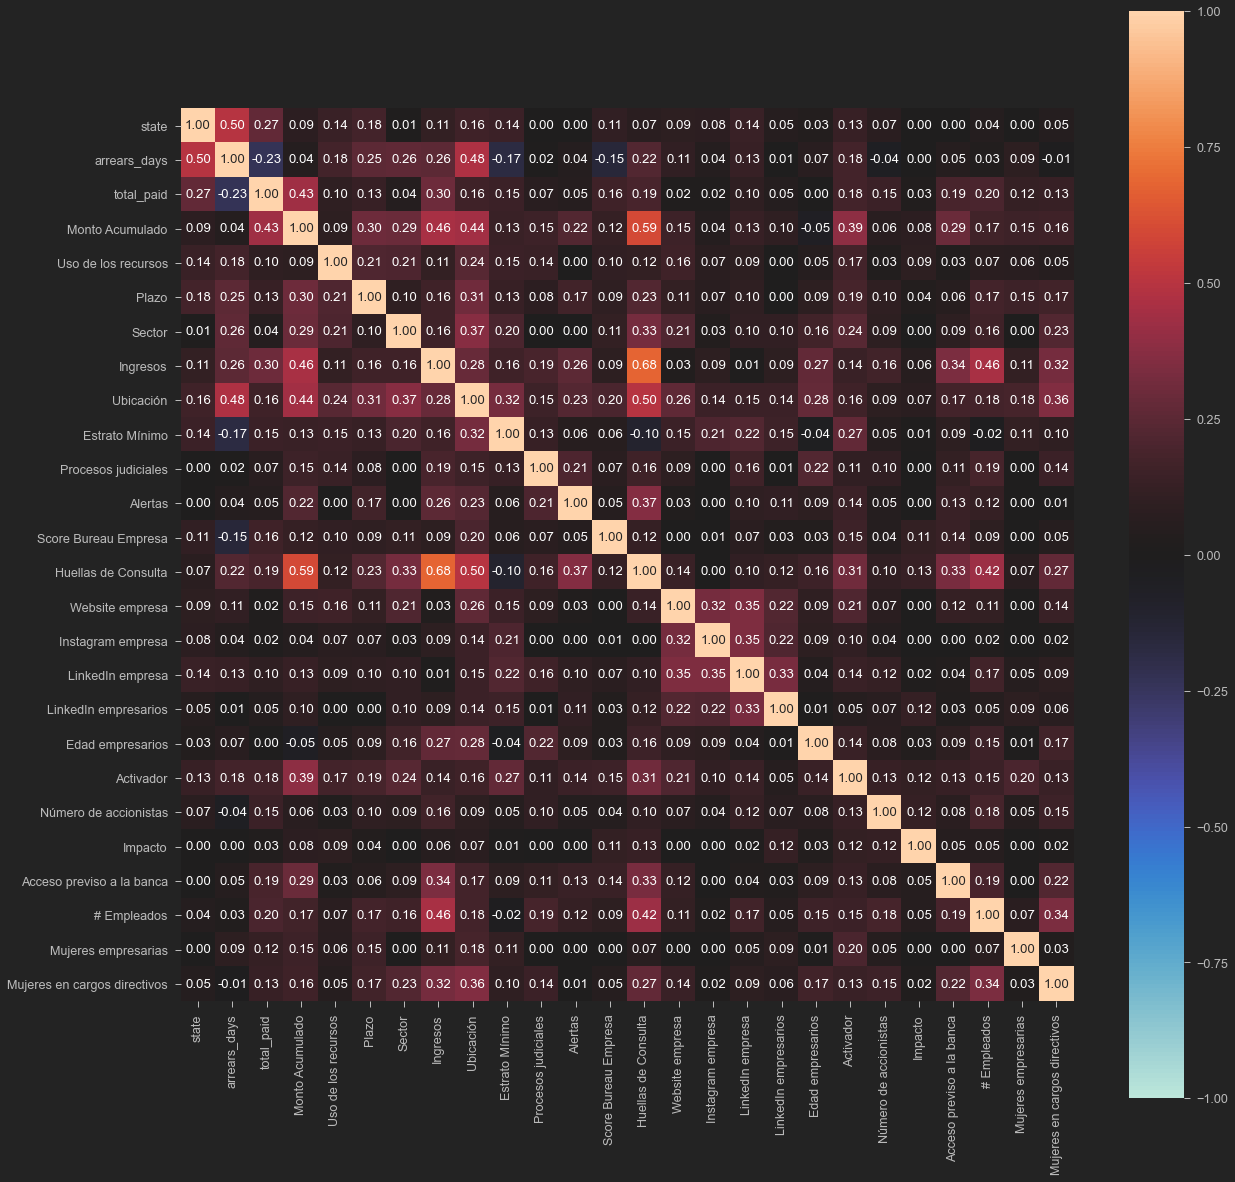

In [82]:
# Graficar correlación entre variables nominales y ordinales
plt.rcParams["figure.figsize"]=20,20
data_associations()

In [83]:
data_transform_2 = data_transform.copy()

In [84]:
data_transform_3 = data_transform_2.copy()

In [85]:
#data_transform_3.set_index(['client_id', 'loan_id'], inplace=True)
#data_transform_3.drop(['level_0', 'index','cluster_id_3', 'cluster_id_2'],axis=1, inplace=True)
#data_transform_3

In [86]:
Num_features=data_transform_3.select_dtypes(include=[np.number]).columns
pt = PowerTransformer()
data_transform_3[Num_features]=pt.fit_transform(data_transform_3[Num_features])
data_transform_3.head()

state  arrears_days  total_paid  Monto Acumulado Uso de los recursos          Plazo     Sector Ingresos Ubicación  Estrato Mínimo Procesos judiciales Alertas  Score Bureau Empresa  Huellas de Consulta Website empresa Instagram empresa LinkedIn empresa LinkedIn empresarios  Edad empresarios                  Activador  Número de accionistas Impacto Acceso previso a la banca  # Empleados Mujeres empresarias  Mujeres en cargos directivos
client_id loan_id                                                                                                                                                                                                                                                                                                                                                                                                                                                      
241       1076     PAID      0.068201    1.990516         0.247658                 CR   25 a 36 meses  Servicios     Seed  Medellín        0.481027                  No      No              0.592443             0.514087              Si                Si               Si                   Si          0.542674                   Internet               0.017484      No                        Si     0.176367                  No                      0.447494
          1244     PAID      0.219112    1.308246         0.247658                 CR   25 a 36 meses  Servicios     Seed  Medellín        0.481027                  No      No              0.592443             0.514087              Si                Si               Si                   Si          0.542674                   Internet               0.017484      No                        Si     0.176367                  No                      0.447494
362       1469     PAID     -0.027869   -0.515458        -1.405435             KT - EX  13 a 24 meses  Servicios     Seed  Medellín       -1.519614                  No      No              0.585245            -0.688637              Si                No               Si                   No         -0.942694             SocialNetworks               0.736474      No                        Si    -1.700640                  No                     -1.459134
428       119      PAID      0.735415   -0.901116        -1.626569                  SP  13 a 24 meses  Industria     Seed  Medellín       -0.523889                  No      No              0.145027            -1.130869              Si                No               Si                   Si          0.451404  CreditProfessionalContact               0.017484      No                        Si    -1.107593                  No                     -1.459134
          120      PAID      0.735415   -0.946665        -1.626569                  SP  13 a 24 meses  Industria     Seed  Medellín       -0.523889                  No      No              0.145027            -1.130869              Si                No               Si                   Si          0.451404  CreditProfessionalContact               0.017484      No                        Si    -1.107593                  No                     -1.459134

#### Data Transformation

In [87]:
# Standardizing all the numerical variables
Num_features=data_transform.select_dtypes(include=[np.number]).columns
data_transform[Num_features]=preprocessing.MinMaxScaler().fit_transform(data_transform[Num_features])
data_transform.head()

state  arrears_days  total_paid  Monto Acumulado Uso de los recursos          Plazo     Sector Ingresos Ubicación  Estrato Mínimo Procesos judiciales Alertas  Score Bureau Empresa  Huellas de Consulta Website empresa Instagram empresa LinkedIn empresa LinkedIn empresarios  Edad empresarios                  Activador  Número de accionistas Impacto Acceso previso a la banca  # Empleados Mujeres empresarias  Mujeres en cargos directivos
client_id loan_id                                                                                                                                                                                                                                                                                                                                                                                                                                                      
241       1076     PAID      0.015697    0.418799         0.173314                 CR   25 a 36 meses  Servicios     Seed  Medellín            0.75                  No      No              0.941955             0.181818              Si                Si               Si                   Si          0.442308                   Internet               0.014706      No                        Si     0.030060                  No                          0.08
          1244     PAID      0.021237    0.260066         0.173314                 CR   25 a 36 meses  Servicios     Seed  Medellín            0.75                  No      No              0.941955             0.181818              Si                Si               Si                   Si          0.442308                   Internet               0.014706      No                        Si     0.030060                  No                          0.08
362       1469     PAID      0.012927    0.043068         0.015756             KT - EX  13 a 24 meses  Servicios     Seed  Medellín            0.25                  No      No              0.940937             0.045455              Si                No               Si                   No          0.192308             SocialNetworks               0.029412      No                        Si     0.004008                  No                          0.00
428       119      PAID      0.059095    0.024672         0.007878                  SP  13 a 24 meses  Industria     Seed  Medellín            0.50                  No      No              0.876782             0.022727              Si                No               Si                   Si          0.423077  CreditProfessionalContact               0.014706      No                        Si     0.008016                  No                          0.00
          120      PAID      0.059095    0.022941         0.007878                  SP  13 a 24 meses  Industria     Seed  Medellín            0.50                  No      No              0.876782             0.022727              Si                No               Si                   Si          0.423077  CreditProfessionalContact               0.014706      No                        Si     0.008016                  No                          0.00

##### Estadística de Hopkins
Prueba la aleatoriedad espacial de los datos e indica la tendencia de agrupación o lo bien que los datos pueden ser agrupados
* 0,5 o menos -->  los datos están distribuidos uniformemente
* 0.77 - 0.99 --> alta tendencia a los cluster 

In [88]:
# Hopkins Statistic is a way of measuring the cluster tendency of a data set.
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan


def hopkins(X):
    d = X.shape[1]
    # d = len(vars) # columns
    n = len(X)  # rows
    m = int(0.1 * n)  # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X, axis=0), np.amax(
            X, axis=0), d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(
            X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0

    return H

In [89]:
#Use a random sample of Data for faster computation
#data_transform = data_transform.sample(200,random_state=41)
#data_transform.head()

In [90]:
#Resetting the indexs
#data_transform=data_transform.reset_index(drop=True)

In [91]:
# Comprobar estadisticamente si la data si se puede clusterizar
Num_features =data_transform.select_dtypes(include=[np.number]).columns
hopkins(data_transform[Num_features])

0.895786882504063

####  Data Modelling

In [92]:
#Use a random sample of Data for faster computation
#Data = data_transform.sample(200,random_state=41)
Data = data_transform.copy()
Data.head()
#Resetting the indexs
#Data=Data.reset_index(drop=True)

#le = preprocessing.LabelEncoder()
#Data['state'] = le.fit_transform(Data.label.values)

#Rename the levels within in the CancellationCode column
Data['state']=Data['state'].replace(['LATE','PAID'],[0,1])
Data['state']=Data['state'].astype(object)

#Data['arrears_days']=Data['arrears_days'].replace(['LATE','PAID'],[0,1])
Data['arrears_days']=Data['arrears_days'].astype(object)

Data['Score Bureau Empresa']=Data['Score Bureau Empresa'].astype(object)

Data.columns

Index(['state', 'arrears_days', 'total_paid', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos'], dtype='object')

In [93]:
Data.shape

(577, 26)

In [94]:
#Getting the list of Numerical and Categorical Variables
num_cols = data_transform._get_numeric_data().columns
print (num_cols)
cols = data_transform.columns
cat_cols = list(set(cols) - set(num_cols))
cat_cols



Index(['arrears_days', 'total_paid', 'Monto Acumulado', 'Estrato Mínimo', 'Score Bureau Empresa', 'Huellas de Consulta', 'Edad empresarios', 'Número de accionistas', '# Empleados', 'Mujeres en cargos directivos'], dtype='object')


['Ingresos',
 'Instagram empresa',
 'Uso de los recursos',
 'Sector',
 'Ubicación',
 'Alertas',
 'Activador',
 'Plazo',
 'state',
 'Mujeres empresarias',
 'Procesos judiciales',
 'Impacto',
 'Acceso previso a la banca',
 'LinkedIn empresarios',
 'LinkedIn empresa',
 'Website empresa']

#### Prinicpal Component Analysis¶

In [159]:
#Selection of variables for PCA
#Data_pca= Data[['state','arrears_days','total_paid', 'Score Bureau Empresa']]
Data_pca= Data[['state','Sector','Ubicación','Activador','Acceso previso a la banca',
                'arrears_days','total_paid', 'Score Bureau Empresa','Huellas de Consulta',
                '# Empleados', 'Mujeres en cargos directivos']]

print (Data_pca.dtypes)

state                            object
Sector                           object
Ubicación                        object
Activador                        object
Acceso previso a la banca        object
arrears_days                     object
total_paid                      float64
Score Bureau Empresa             object
Huellas de Consulta             float64
# Empleados                     float64
Mujeres en cargos directivos    float64
dtype: object


In [160]:
pca = PCA()
Num_features=Data_pca.select_dtypes(include=[np.number]).columns
pca.fit(Data_pca[Num_features])

PCA()

In [239]:
#pca.explained_variance_ratio_

array([0.54639659, 0.22065339])

In [ ]:
----

###### Mirar el número de componentes

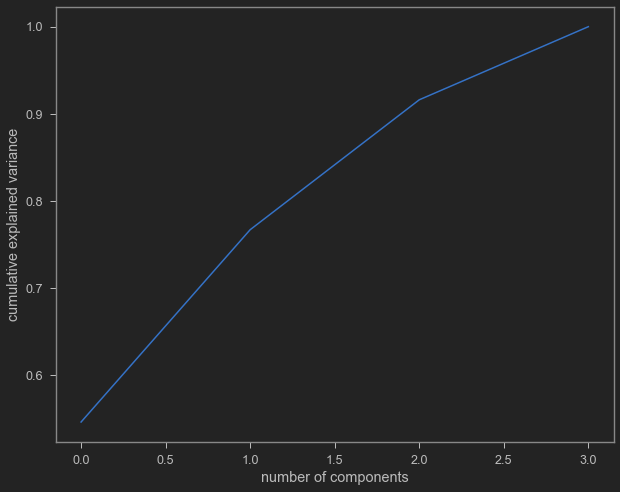

In [161]:
plt.figure(figsize=(10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [242]:
#Principal Component
pca = PCA(n_components=2, whiten=True)
Num_features=Data_pca.select_dtypes(include=[np.number]).columns
x=Data_pca[Num_features]
principalComponents = pca.fit_transform(x)

# Cumulative Explained Variance
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

print(cum_explained_var)

[0.5463965926336994, 0.7670499840959564]


In [297]:
#Principal Components converted to a Data frame
principalDf_pca  = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf_pca.shape

(577, 2)

In [298]:
principalDf_pca.head(1)

,principal component 1,principal component 2
0,0.42048,2.390433


In [245]:
Data_pca.reset_index(inplace=True)

In [246]:
Data_pca.head(1)

,index,state,Sector,Ubicación,Activador,Acceso previso a la banca,arrears_days,total_paid,Score Bureau Empresa,Huellas de Consulta,# Empleados,Mujeres en cargos directivos
0,0,1,Servicios,Medellín,Internet,Si,0.0156971,0.418799,0.941955,0.181818,0.03006,0.08


In [247]:
#Data_pca.drop(['client_id', 'loan_id'], axis= 1, inplace=True)
Data_pca.drop(['index'], axis= 1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [251]:
Data_pca.columns

Index(['state', 'Sector', 'Ubicación', 'Activador', 'Acceso previso a la banca', 'arrears_days', 'total_paid', 'Score Bureau Empresa', 'Huellas de Consulta', '# Empleados', 'Mujeres en cargos directivos'], dtype='object')

In [257]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat = pd.concat([principalDf, Data_pca['arrears_days']], axis = 1)
#finalDf_Cat = principalDf
finalDf_Cat.head(2)

,principal component 1,principal component 2,arrears_days
0,0.420480,2.390433,0.0156971
1,0.224627,1.126977,0.0212373


In [ ]:
categorical_columns = [0, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16,
                      17,19, 21, 22, 24, 25] #make sure to specify correct indices

<function matplotlib.pyplot.show(*args, **kw)>

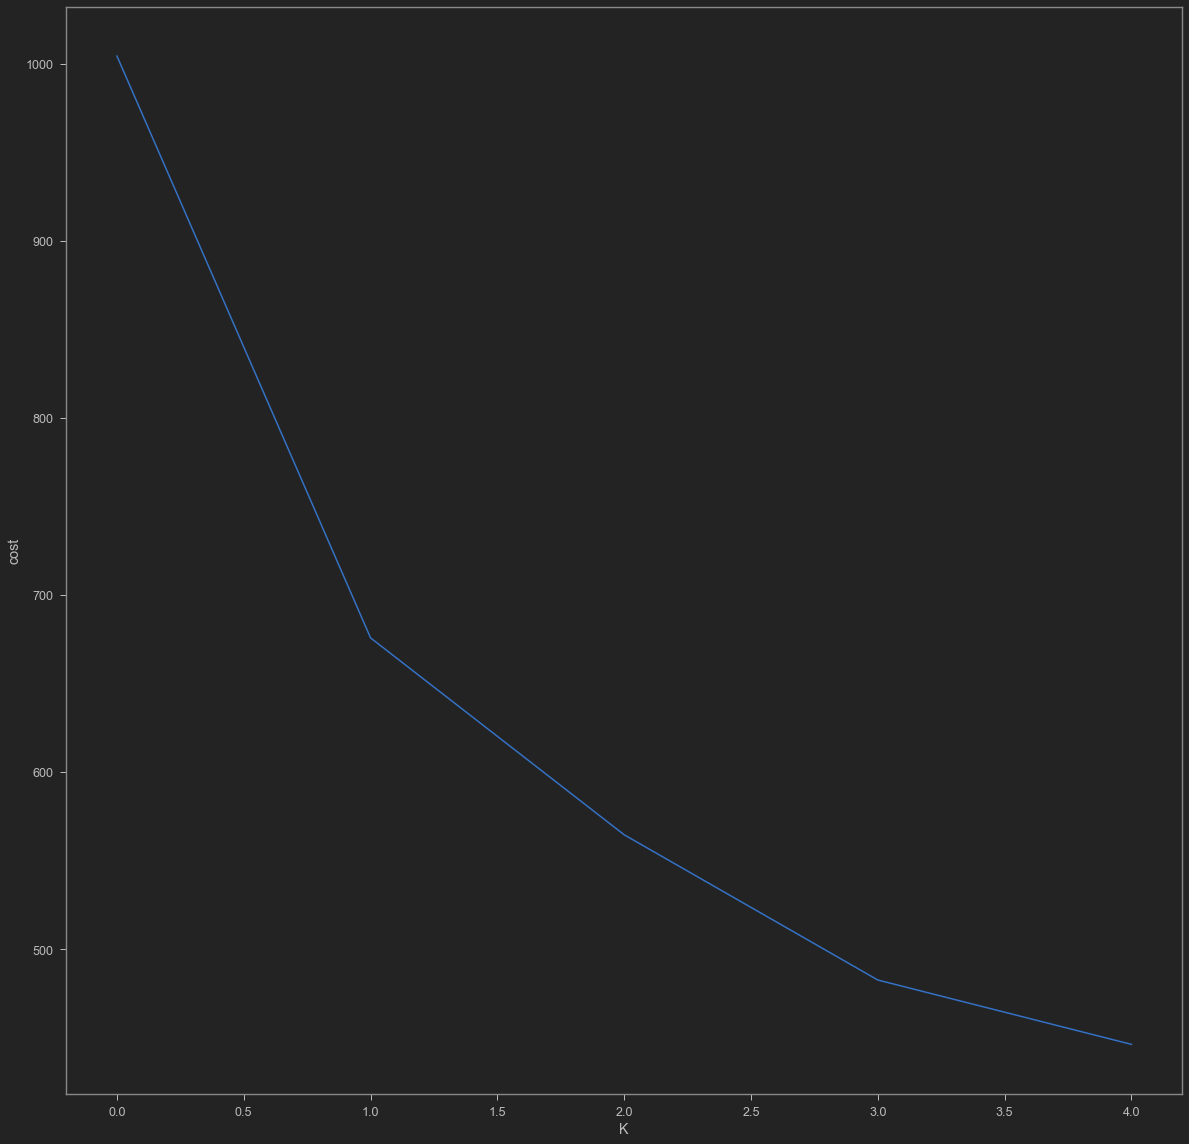

In [107]:
#Choosing optimal K value
cost = []
X = finalDf_Cat
for num_clusters in list(range(2,7)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=15,n_init=50) 
    kproto.fit_predict(X, categorical=[2])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [258]:
# Converting the dataset into matrix
X = finalDf_Cat.to_numpy()

<function matplotlib.pyplot.show(*args, **kw)>

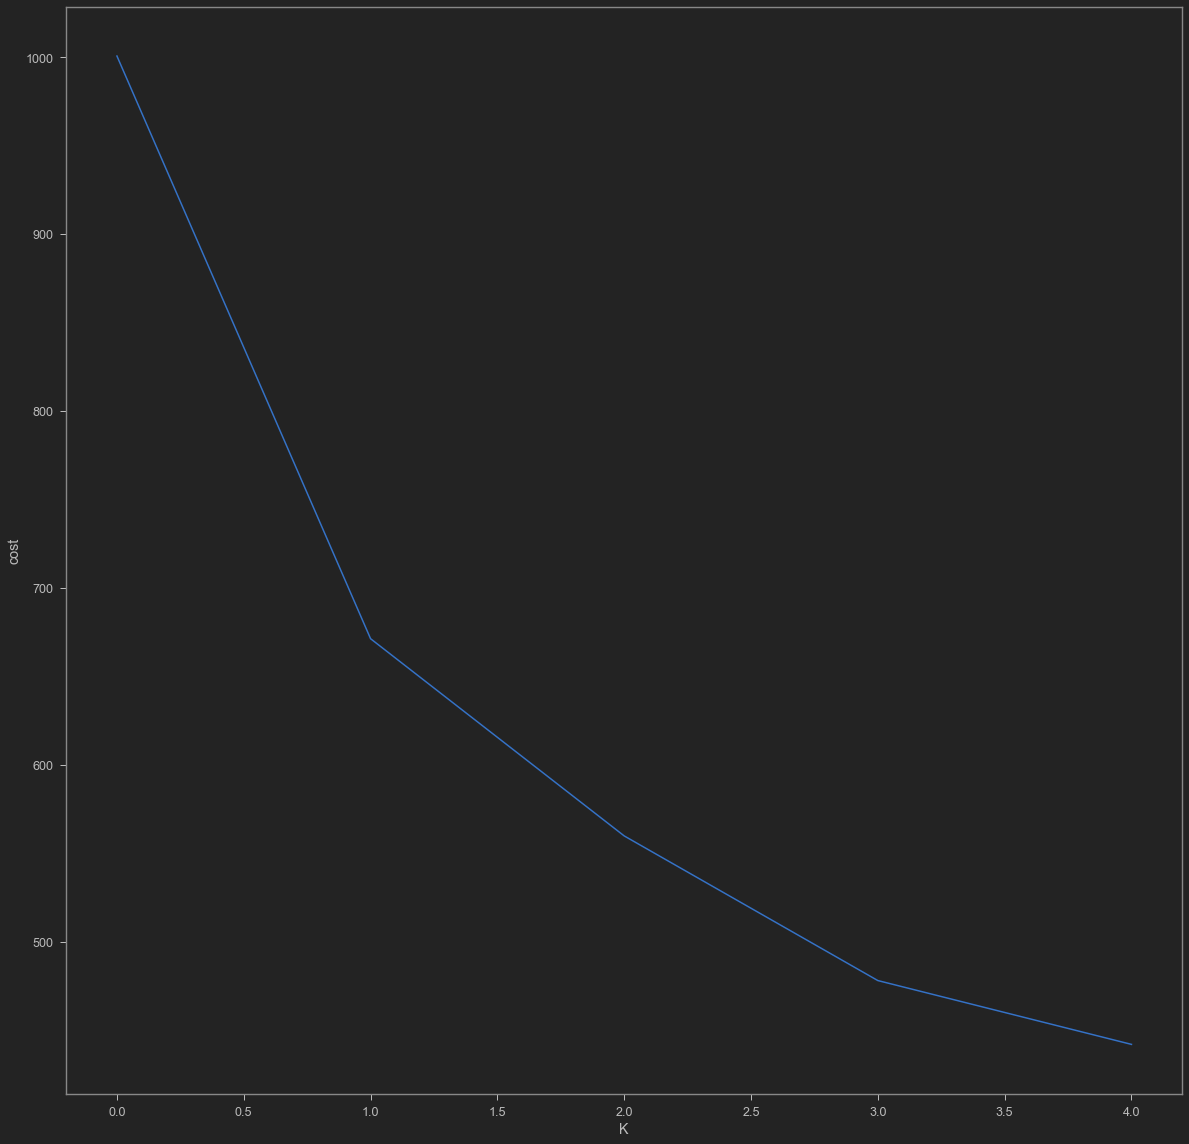

In [158]:
#Choosing optimal K value
cost = []
X = finalDf_Cat
for num_clusters in list(range(2,7)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=15,n_init=50) 
    kproto.fit_predict(X, categorical=[2])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [259]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-20,gamma=.25) 
clusters = kproto.fit_predict(X, categorical=[2])

###### PCA con arrears_days

0    447
1    130
Name: Cluster_id, dtype: int64


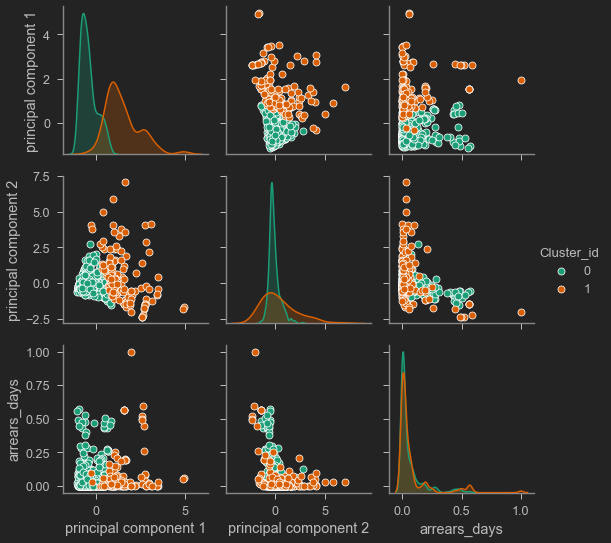

In [260]:
#Visualize K-Prototype clustering on the PCA projected Data
df=pd.DataFrame(finalDf_Cat)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

###### PCA con state

In [112]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat = pd.concat([principalDf, Data_pca['state']], axis = 1)
#finalDf_Cat = principalDf
finalDf_Cat.head(2)

,principal component 1,principal component 2,state
0,0.420480,2.390433,1
1,0.224627,1.126977,1


In [152]:
# Converting the dataset into matrix
X = finalDf_Cat.to_numpy()

In [153]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=3, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-20,gamma=.25) 
clusters = kproto.fit_predict(X, categorical=[2])

2    409
0    116
1     52
Name: Cluster_id, dtype: int64


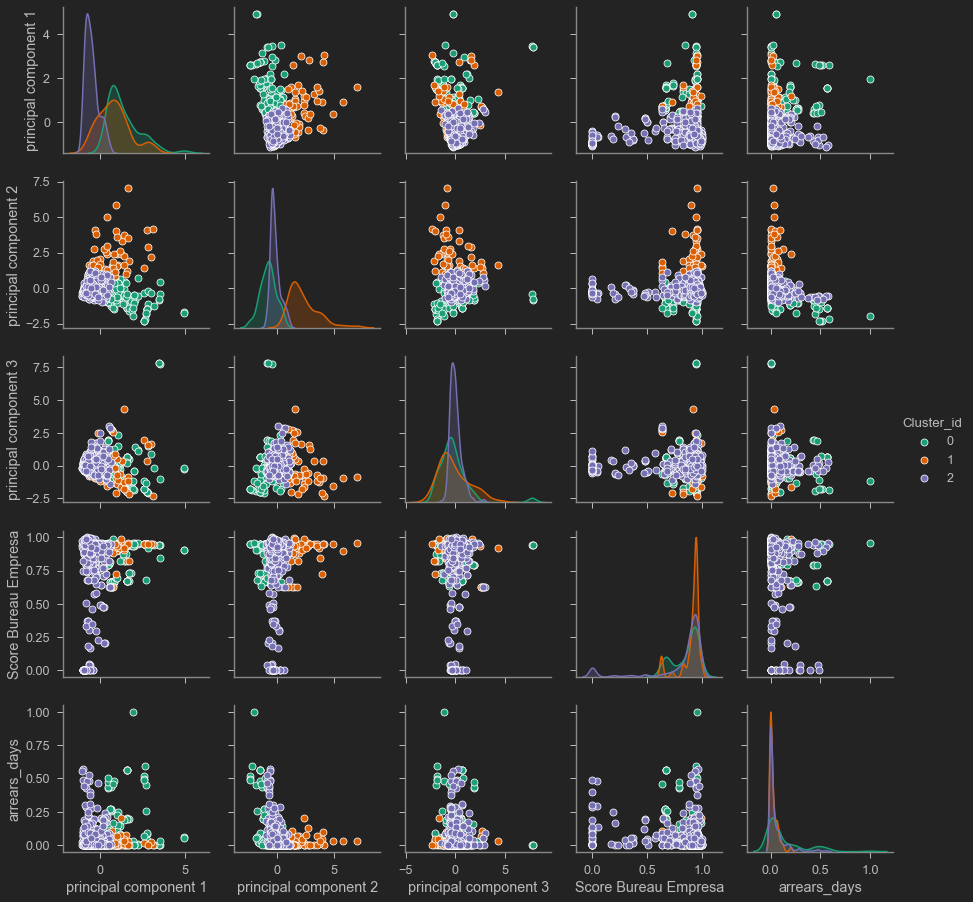

In [154]:
#Visualize K-Prototype clustering on the PCA projected Data
df=pd.DataFrame(finalDf_Cat)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

###### PCA con Score Bureau

In [119]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat = pd.concat([principalDf, Data_pca['Score Bureau Empresa']], axis = 1)
#finalDf_Cat = principalDf
finalDf_Cat.head(2)

,principal component 1,principal component 2,Score Bureau Empresa
0,0.420480,2.390433,0.941955
1,0.224627,1.126977,0.941955


In [120]:
# Converting the dataset into matrix
X = finalDf_Cat.to_numpy()

In [121]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-20,gamma=.25) 
clusters = kproto.fit_predict(X, categorical=[2])

0    446
1    131
Name: Cluster_id, dtype: int64


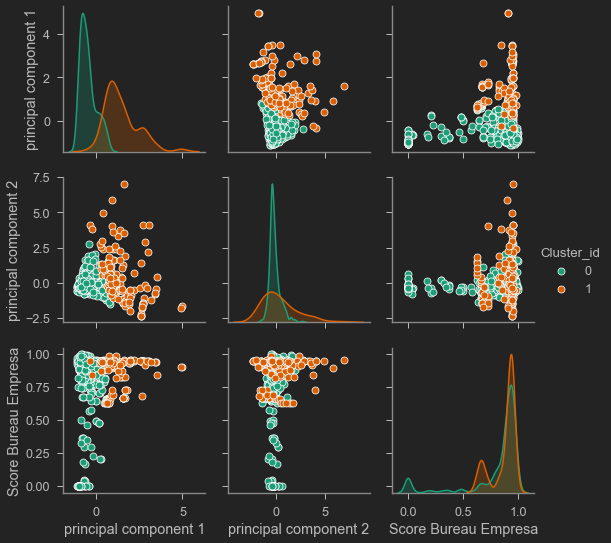

In [122]:
#Visualize K-Prototype clustering on the PCA projected Data
df=pd.DataFrame(finalDf_Cat)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

###### PCA con Score Bureau y arrears_days

In [301]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat_PCA = pd.concat([principalDf_pca, Data_pca[['Score Bureau Empresa', 'arrears_days']]], axis = 1)
#finalDf_Cat = principalDf
finalDf_Cat_PCA.head(2)

,principal component 1,principal component 2,Score Bureau Empresa,arrears_days
0,0.420480,2.390433,0.941955,0.0156971
1,0.224627,1.126977,0.941955,0.0212373


In [302]:
# Converting the dataset into matrix
array_pca = finalDf_Cat_PCA.to_numpy()

In [125]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-20,gamma=.25) 
clusters = kproto.fit_predict(array_pca, categorical=[2, 3])

1    446
0    131
Name: Cluster_id, dtype: int64


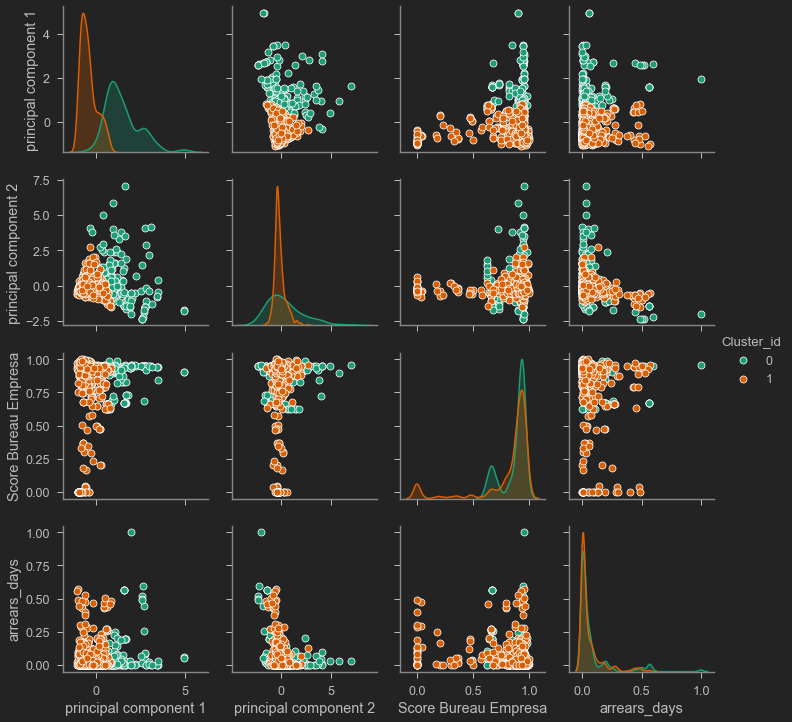

In [126]:
#Visualize K-Prototype clustering on the PCA projected Data
df=pd.DataFrame(finalDf_Cat)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

###### Con tres componentes

In [127]:
#Principal Component
pca = PCA(n_components=3, whiten=True)
Num_features=Data_pca.select_dtypes(include=[np.number]).columns
x=Data_pca[Num_features]
principalComponents = pca.fit_transform(x)

# Cumulative Explained Variance
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

print(cum_explained_var)

[0.5463965926336997, 0.767049984095957, 0.9161143793702655]


In [129]:
#Principal Components converted to a Data frame
principalDf  = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
principalDf.shape

(577, 3)

In [130]:
principalDf.head(1)

,principal component 1,principal component 2,principal component 3
0,0.42048,2.390433,-0.692551


In [131]:
Data_pca.reset_index(inplace=True)

In [132]:
Data_pca.head(1)

,index,state,Sector,Ubicación,Activador,Acceso previso a la banca,arrears_days,total_paid,Score Bureau Empresa,Huellas de Consulta,# Empleados,Mujeres en cargos directivos
0,0,1,Servicios,Medellín,Internet,Si,0.0156971,0.418799,0.941955,0.181818,0.03006,0.08


In [134]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat = pd.concat([principalDf, Data_pca['arrears_days']], axis = 1)
#finalDf_Cat = principalDf
finalDf_Cat.head(2)

,principal component 1,principal component 2,principal component 3,arrears_days
0,0.420480,2.390433,-0.692551,0.0156971
1,0.224627,1.126977,-0.383122,0.0212373


In [ ]:
categorical_columns = [0, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16,
                      17,19, 21, 22, 24, 25] #make sure to specify correct indices

In [135]:
# Converting the dataset into matrix
X = finalDf_Cat.to_numpy()

In [136]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-20,gamma=.25) 
clusters = kproto.fit_predict(X, categorical=[2])

###### PCA con arrears_days

1    447
0    130
Name: Cluster_id, dtype: int64


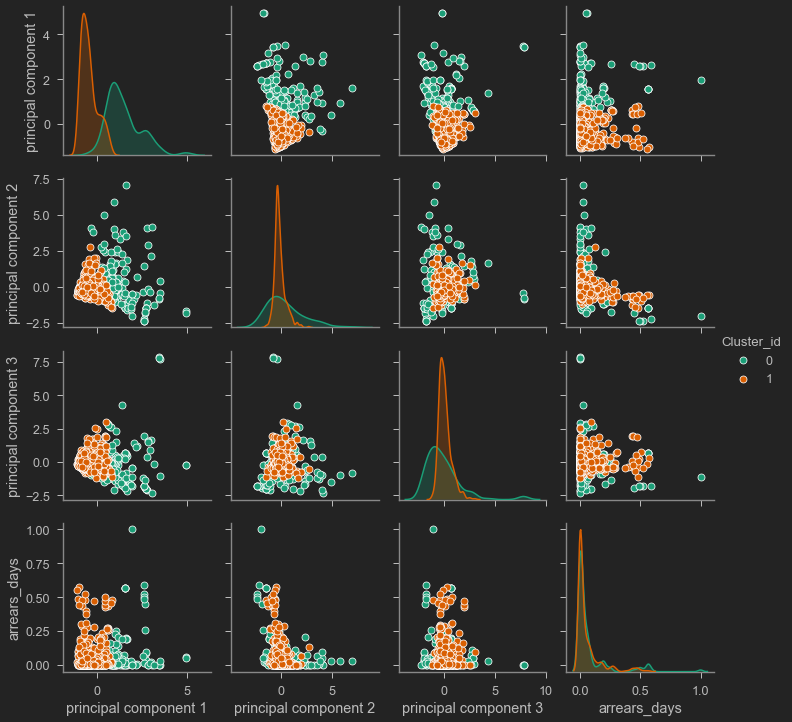

In [137]:
#Visualize K-Prototype clustering on the PCA projected Data
df=pd.DataFrame(finalDf_Cat)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

###### PCA con state

In [138]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat = pd.concat([principalDf, Data_pca['state']], axis = 1)
#finalDf_Cat = principalDf
finalDf_Cat.head(2)

,principal component 1,principal component 2,principal component 3,state
0,0.420480,2.390433,-0.692551,1
1,0.224627,1.126977,-0.383122,1


In [139]:
# Converting the dataset into matrix
X = finalDf_Cat.to_numpy()

In [140]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-20,gamma=.25) 
clusters = kproto.fit_predict(X, categorical=[2])

1    445
0    132
Name: Cluster_id, dtype: int64


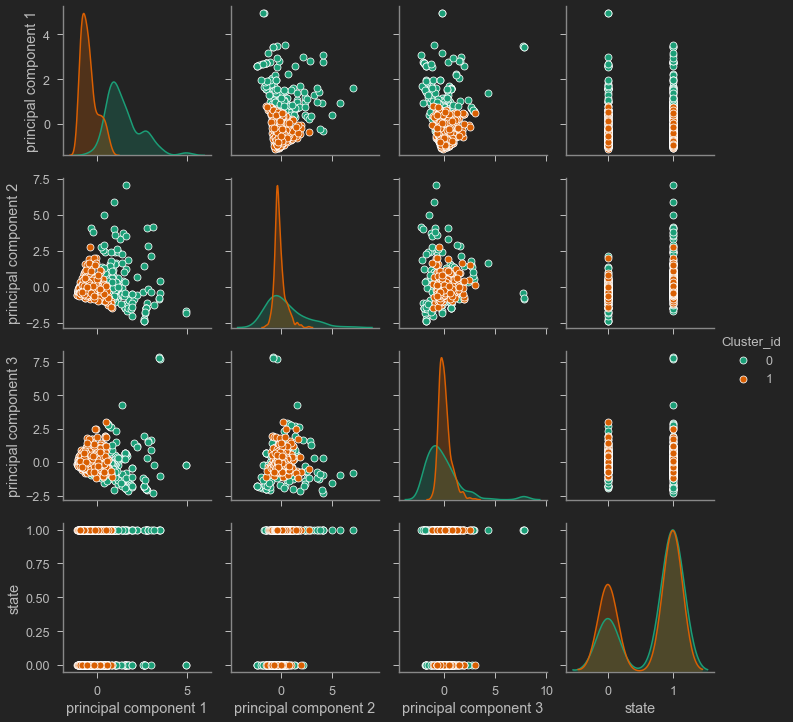

In [141]:
#Visualize K-Prototype clustering on the PCA projected Data
df=pd.DataFrame(finalDf_Cat)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

###### PCA con Score Bureau

In [142]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat = pd.concat([principalDf, Data_pca['Score Bureau Empresa']], axis = 1)
#finalDf_Cat = principalDf
finalDf_Cat.head(2)

,principal component 1,principal component 2,principal component 3,Score Bureau Empresa
0,0.420480,2.390433,-0.692551,0.941955
1,0.224627,1.126977,-0.383122,0.941955


In [143]:
# Converting the dataset into matrix
X = finalDf_Cat.to_numpy()

In [144]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-20,gamma=.25) 
clusters = kproto.fit_predict(X, categorical=[2])

1    447
0    130
Name: Cluster_id, dtype: int64


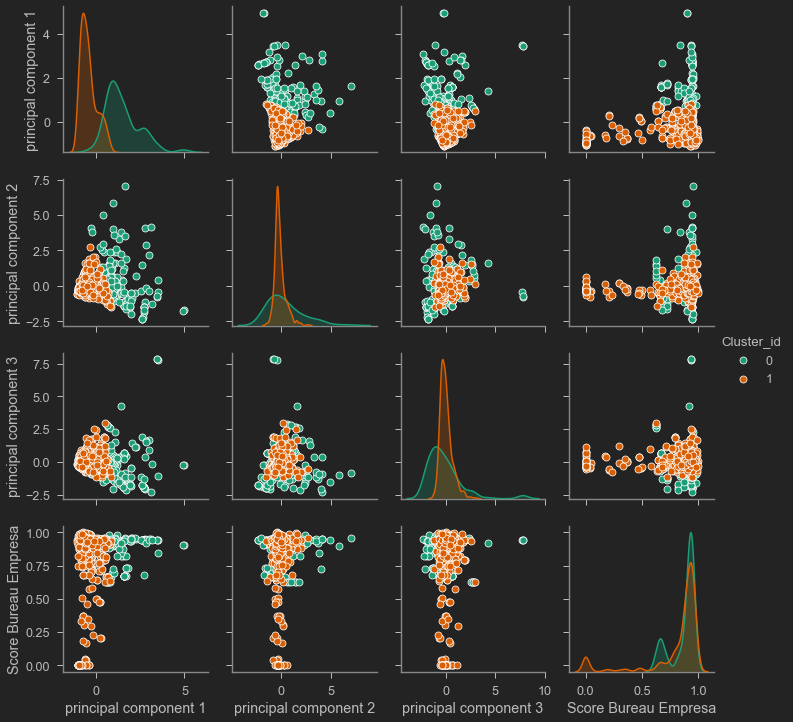

In [145]:
#Visualize K-Prototype clustering on the PCA projected Data
df=pd.DataFrame(finalDf_Cat)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

###### PCA con Score Bureau y arrears_days

In [146]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat = pd.concat([principalDf, Data_pca[['Score Bureau Empresa', 'arrears_days']]], axis = 1)
#finalDf_Cat = principalDf
finalDf_Cat.head(2)

,principal component 1,principal component 2,principal component 3,Score Bureau Empresa,arrears_days
0,0.420480,2.390433,-0.692551,0.941955,0.0156971
1,0.224627,1.126977,-0.383122,0.941955,0.0212373


In [147]:
# Converting the dataset into matrix
X = finalDf_Cat.to_numpy()

In [148]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-20,gamma=.25) 
clusters = kproto.fit_predict(X, categorical=[2, 3])

0    446
1    131
Name: Cluster_id, dtype: int64


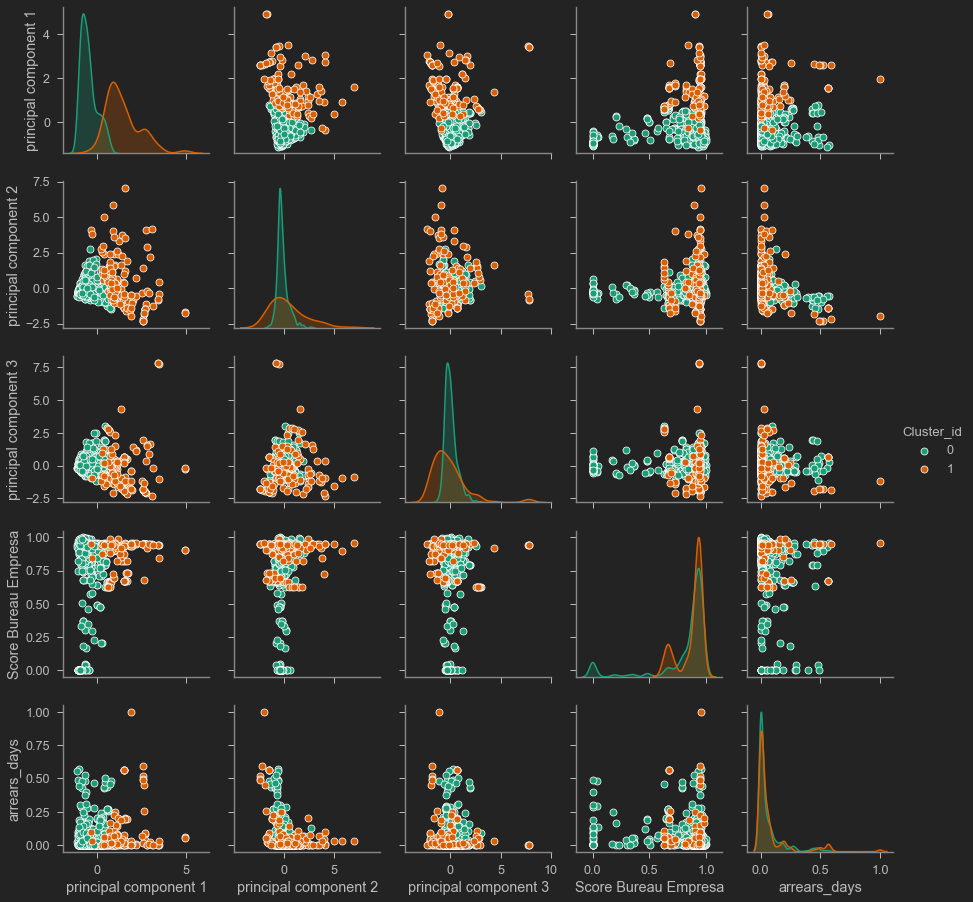

In [149]:
#Visualize K-Prototype clustering on the PCA projected Data
df=pd.DataFrame(finalDf_Cat)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

In [ ]:
#Visualize K-Prototype clustering on the PCA projected Data
#df=pd.DataFrame(finalDf_Cat)
#df['Cluster_id']=clusters
#print(df['Cluster_id'].value_counts())
#sns_plot = sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')
#sns_plot.savefig("output.png")

In [211]:
data_transform_2.head(1)

,,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos
client_id,loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,
241,1076,PAID,17,147915805,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2


In [221]:
data_transform_2.reset_index(inplace=True)
data_transform_2.drop(['client_id', 'loan_id'], axis=1, inplace=True)

##### Factor Analysis of Mixed Data (FAMD)

In [268]:
import prince
famd = prince.FAMD(
     n_components=2,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
)
famd = famd.fit(data_transform_2)
transformada = famd.transform(data_transform_2)

In [269]:
Y = transformada.to_numpy()
Y

array([[ 0.33019385, -1.15089516],
       [ 0.10980077, -0.85522795],
       [-1.15831732, -0.10024543],
       ...,
       [-0.58997817,  0.43499382],
       [ 0.53891147, -1.41304314],
       [-0.84734788,  1.15023486]])

In [214]:
famd.row_coordinates(data_transform_2)

0         1
client_id loan_id                    
241       1076     0.330194 -1.150895
          1244     0.109801 -0.855228
362       1469    -1.158317 -0.100245
428       119     -0.796127  0.094075
          120     -0.798556  0.097125
...                     ...       ...
6734      1499    -1.041348 -0.289813
6982      1503    -0.136254 -0.142578
7008      1593    -0.589978  0.434994
7145      1492     0.538911 -1.413043
7279      1595    -0.847348  1.150235

[577 rows x 2 columns]

In [335]:
#Principal Components converted to a Data frame
principalDf_famd  = pd.DataFrame(data = Y
             , columns = ['principal component 1', 'principal component 2'])
principalDf_famd.shape

(577, 2)

In [336]:
principalDf_famd.head(1)

,principal component 1,principal component 2
0,0.330194,-1.150895


In [337]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat_famd = pd.concat([principalDf_famd, Data_pca[['arrears_days']]], axis = 1)
#finalDf_Cat = principalDf
finalDf_Cat_famd.head(2)

,principal component 1,principal component 2,arrears_days
0,0.330194,-1.150895,0.0156971
1,0.109801,-0.855228,0.0212373


<function matplotlib.pyplot.show(*args, **kw)>

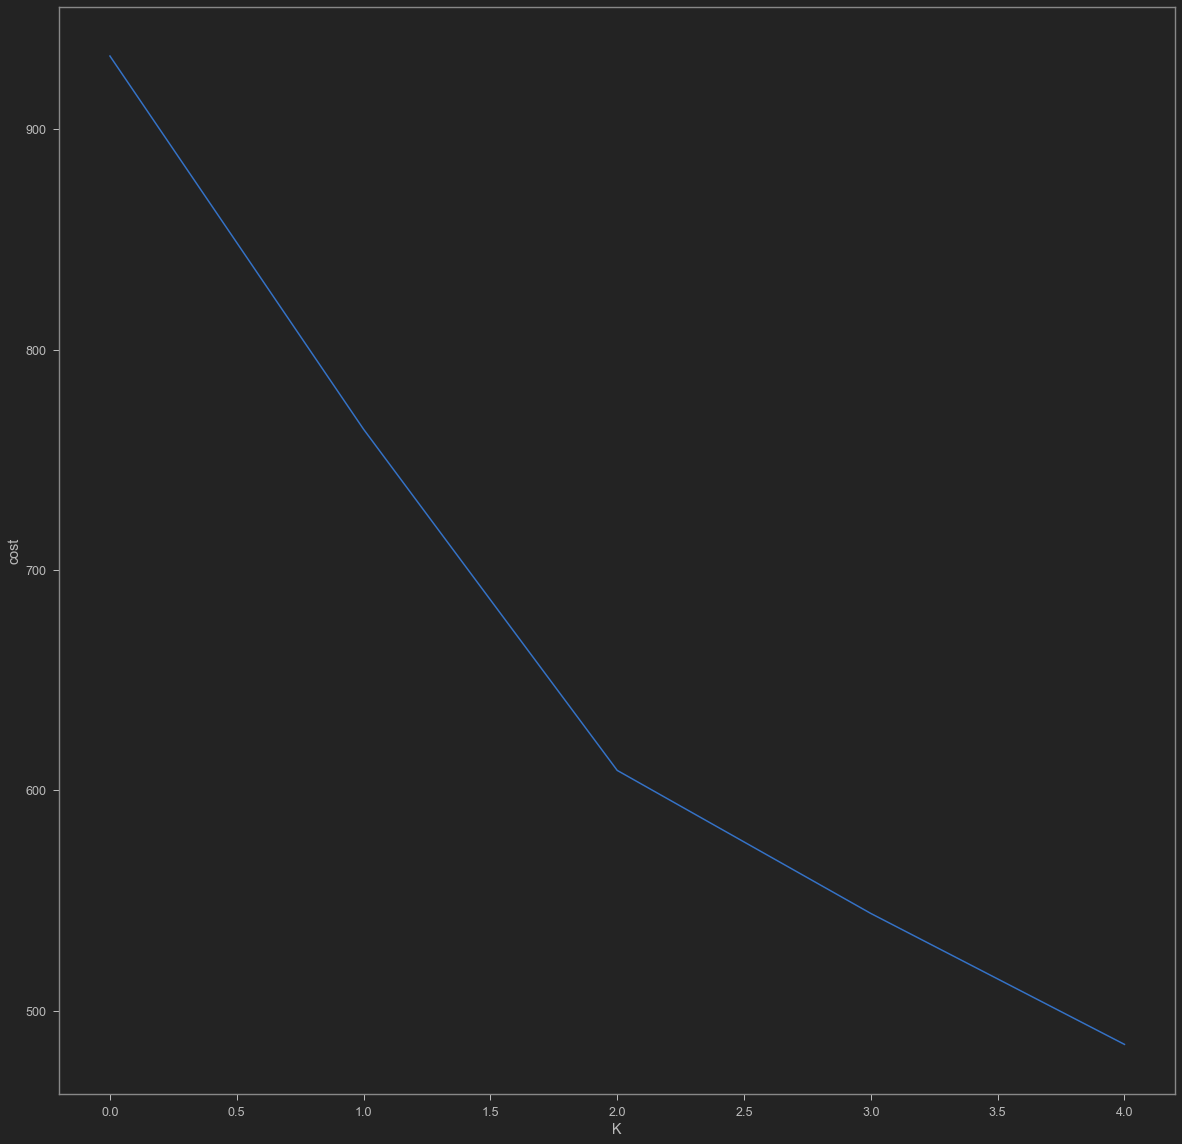

In [238]:
#Choosing optimal K value
cost = []
Z_famd = finalDf_Cat_famd
for num_clusters in list(range(2,7)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=15,n_init=50) 
    kproto.fit_predict(Z_famd, categorical=[2])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [338]:
# Converting the dataset into matrix
Z_famd = finalDf_Cat_famd.to_numpy()

In [236]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-20,gamma=.25) 
clusters = kproto.fit_predict(Z_famd, categorical=[2])

0    435
1    142
Name: Cluster_id, dtype: int64


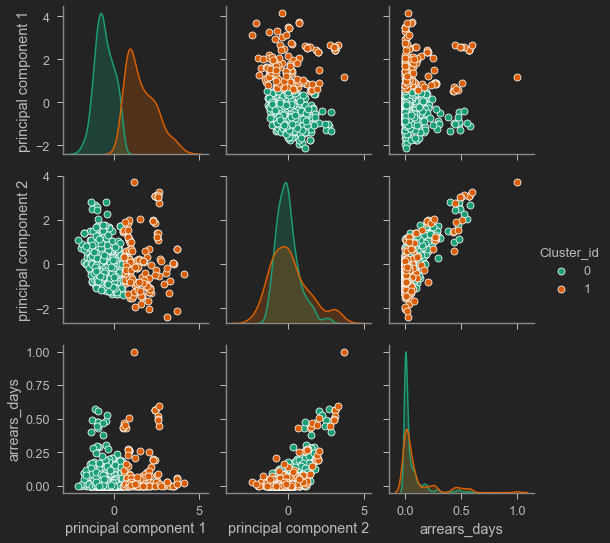

In [237]:
#Visualize K-Prototype clustering on the PCA projected Data
df=pd.DataFrame(finalDf_Cat_famd)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

###### FAMD Score Bureau

In [271]:
#Concatenating the PCAs with the categorical variable
finalDf_Cat_famd = pd.concat([principalDf_famd, Data_pca[['Score Bureau Empresas']]], axis = 1)
#finalDf_Cat = principalDf
finalDf_Cat_famd.head(2)

,principal component 1,principal component 2,Score Bureau Empresa
0,0.330194,-1.150895,0.941955
1,0.109801,-0.855228,0.941955


In [272]:
# Converting the dataset into matrix
Z_famd = finalDf_Cat_famd.to_numpy()

In [273]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-20,gamma=.25) 
clusters = kproto.fit_predict(Z_famd, categorical=[2])

0    435
1    142
Name: Cluster_id, dtype: int64


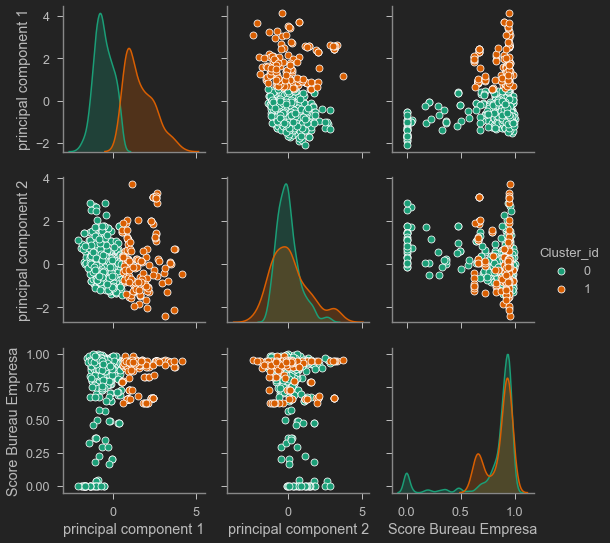

In [274]:
#Visualize K-Prototype clustering on the PCA projected Data
df=pd.DataFrame(finalDf_Cat_famd)
df['Cluster_id']=clusters
print(df['Cluster_id'].value_counts())
sns.pairplot(df,hue='Cluster_id',palette='Dark2',diag_kind='kde')

#### DBSCAN Clustering Algorithm

In [ ]:
#Selection of numerical variables for DBSCAN
Data_DBSCAN = Data.select_dtypes(exclude='object')

In [ ]:
Data_DBSCAN.head()

In [ ]:
#selection of eps value
from sklearn.neighbors import NearestNeighbors
nbrs=NearestNeighbors().fit(Data_DBSCAN)
distances, indices = nbrs.kneighbors(Data_DBSCAN,20)
kDis = distances[:,10]
kDis.sort()
kDis = kDis[range(len(kDis)-1,0,-1)]
plt.plot(range(0,len(kDis)),kDis)
plt.xlabel('Distance')
plt.ylabel('eps')
plt.show()

In [ ]:
#DBSCAN Algorithm
from sklearn.cluster import DBSCAN
dbs_1= DBSCAN(eps=0.6, min_samples=4)
results = dbs_1.fit(Data_DBSCAN).labels_

In [ ]:
#Visualize DBSCAN clustering 
df_DBSCAN=Data_DBSCAN
df_DBSCAN['Cluster_id_DBSCAN']=results
print (df_DBSCAN['Cluster_id_DBSCAN'].value_counts())
sns.pairplot(df_DBSCAN,hue='Cluster_id_DBSCAN',palette='Dark2',diag_kind='kde')

In [ ]:
Data.columns

##### Kprototype Clustering Algorithm

In [ ]:
#Selection of variables for Kprototype Clustering Algorithm
#Data_k= Data[['state','arrears_days','total_paid', 'Score Bureau Empresa']]
Data_k = Data[['state', 'arrears_days', 'total_paid', 'Monto Acumulado', 'Uso de los recursos', 'Plazo', 'Sector', 'Ingresos', 'Ubicación', 'Estrato Mínimo', 'Procesos judiciales', 'Alertas', 'Score Bureau Empresa', 'Huellas de Consulta', 'Website empresa', 'Instagram empresa', 'LinkedIn empresa', 'LinkedIn empresarios', 'Edad empresarios', 'Activador', 'Número de accionistas', 'Impacto', 'Acceso previso a la banca', '# Empleados', 'Mujeres empresarias', 'Mujeres en cargos directivos']]
print (Data_k.dtypes)

In [ ]:
i=0
for val in range(len(Data_k.columns)):
    print(f'indice {i}: {Data_k.columns[val]}')
    i+= 1

In [ ]:
categorical_columns = [0, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16,
                      17,19, 21, 22, 24, 25] #make sure to specify correct indices

In [ ]:
#Choosing optimal K value
cost = []
X = Data_k
for num_clusters in list(range(2,7)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=1,max_iter=15,n_init=50) 
    kproto.fit_predict(X, categorical=categorical_columns)
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

In [ ]:
# Converting the dataset into matrix
X = Data_k.to_numpy()

In [ ]:
# Running K-Prototype clustering
kproto = KPrototypes(n_clusters=2, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=0.15) 
clusters = kproto.fit_predict(X, categorical=categorical_columns)

In [ ]:
#Visualize K-Prototype clustering 
df_state=pd.DataFrame(Data_k)
df_state['Cluster_id_K_Prototype']=clusters
print (df_state['Cluster_id_K_Prototype'].value_counts())
sns.pairplot(df_state,hue='Cluster_id_K_Prototype',palette='Dark2',diag_kind='kde')
plt.show()

In [ ]:
df_state.head(1)

#### Cluster Agreement

In [ ]:
df_state.head(1)

In [ ]:
df_DBSCAN.head(1)

In [ ]:
Data

In [ ]:
#join DBScan and K-prototype data frames
Clusters=pd.concat([df_state, Data, df_DBSCAN], axis = 1)
Clusters=Clusters.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 63]]
Clusters.head()

In [ ]:
i=0
for val in range(len(Data.columns)):
    print(f'indice {i}: {Data.columns[val]}')
    i+= 1

Analizar los acuerdos de clúster entre DBSCAN y K-prototype para 10 pares de valores aleatorios. 

In [ ]:
#Verify if randow rows have the same cluster Id between DBScan and K-Prototype
random_rows=Clusters.sample(20,random_state=36)
random_rows.iloc[:, [0,1,2,7,12,13,26,27]]


Lo anterior fueron 20 filas aleatorias de datos con los identificadores de grupo de ambos modelos. 

In [ ]:
# OneHotEncoding para variables categoricas
column_trans = make_column_transformer(
    (OneHotEncoder(), columnas_OHE),
    remainder='passthrough')

#normalizada = column_trans.fit_transform(data_transform)

In [ ]:
#Preprocessing numerical
numerical = data_transform_2.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = data_transform_2.select_dtypes(include='object')
#print(categorical)
#label_encoder = preprocessing.LabelEncoder()
le = preprocessing.LabelEncoder()
categorical= categorical[columnas_OHE].apply(le.fit_transform)
#categorical = label_encoder.fit(categorical)

#categorical = column_trans.fit_transform(categorical)

#categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(data_transform_2.select_dtypes(include='object').columns) / data_transform_2.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

In [ ]:
categorical_weight

### K-prototypes

In [ ]:
data_transform_2

In [ ]:
kprot_data = data_transform_2.copy()
for c in data_transform.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

In [ ]:
kprot_data_array = kprot_data.values

In [ ]:
categorical_columns = [1, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16,
                      17, 18, 20, 21, 22, 23, 25] #make sure to specify correct indices

In [ ]:
kproto_3 = KPrototypes(n_clusters= 3, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_3 = kproto_3.fit_predict(kprot_data_array, categorical=categorical_columns)

In [ ]:
kproto_2 = KPrototypes(n_clusters= 2, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_2 = kproto_2.fit_predict(kprot_data_array, categorical=categorical_columns)

In [ ]:
clusters_kproto=pd.DataFrame(data_transform_2)
clusters_kproto['cluster_id_2'] = clusters_2
clusters_kproto['cluster_id_3'] = clusters_3
clusters_kproto.reset_index(inplace=True)
#clusters_kproto.drop(['index', 'level_0'],axis=1, inplace=True)

In [ ]:
clusters_kproto.head()

In [ ]:
clusters_kproto.to_csv('clusters.csv')

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_2', data=clusters_kproto)

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_3', data=clusters_kproto)

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', x='Activador', data=clusters_kproto)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', x='Activador', data=clusters_kproto)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', y='Plazo', data=clusters_kproto)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', y='Plazo', data=clusters_kproto)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='arrears_days', data=clusters_kproto, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Score Bureau Empresa', data=clusters_kproto, kind='box')
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Score Bureau Empresa', data=clusters_kproto, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Huellas de Consulta', data=clusters_kproto, kind='bar')
plt.xticks(rotation=90)
plt.show()

### K-prototypes con PCA con Score

In [ ]:
#cat_num = [0,1,2,3,4,7,8]
X

In [ ]:
kproto_3 = KPrototypes(n_clusters= 3, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_3 = kproto_3.fit_predict(X, categorical=[3])

In [ ]:
kproto_2 = KPrototypes(n_clusters= 2, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_2 = kproto_2.fit_predict(X, categorical=[3])

In [ ]:
clusters_2.shape

In [ ]:
clusters_kproto=pd.DataFrame(data_transform_2)
clusters_kproto
clusters_kproto['cluster_id_2'] = clusters_2
clusters_kproto['cluster_id_3'] = clusters_3
clusters_kproto.reset_index(inplace=True)
#clusters_kproto.drop(['index', 'level_0'],axis=1, inplace=True)

In [ ]:
clusters_kproto.drop(['index', 'level_0'],axis=1, inplace=True)

In [ ]:
clusters_kproto.head()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_2', data=clusters_kproto)

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_3', data=clusters_kproto)

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', x='Activador', data=clusters_kproto)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', x='Activador', data=clusters_kproto)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', y='Plazo', data=clusters_kproto)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', y='Plazo', data=clusters_kproto)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='arrears_days', data=clusters_kproto, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [ ]:
clusters_kproto.groupby('cluster_id_2')['arrears_days'].mean()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Score Bureau Empresa', data=clusters_kproto, kind='box')
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Score Bureau Empresa', data=clusters_kproto, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [ ]:
clusters_kproto.groupby('cluster_id_2')['Score Bureau Empresa'].mean()

In [ ]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Huellas de Consulta', data=clusters_kproto, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [ ]:
clusters_kproto.groupby('cluster_id_2')['Huellas de Consulta'].mean()

### K-prototypes con PCA con Score  y arrears_days

In [303]:
array_pca

array([[0.420479623496515, 2.390432591709005, 0.9419551934826883,
        0.01569713758079409],
       [0.22462715831444857, 1.126977406469992, 0.9419551934826883,
        0.02123730378578024],
       [-0.8339397116118268, -0.34979261896161995, 0.9409368635437881,
        0.012927054478301015],
       ...,
       [-0.5344767041293477, 0.010987744453586412, 0.9276985743380854,
        0.05263157894736842],
       [-0.1356249256791678, 1.5139168613030236, 0.9368635437881873, 0.0],
       [-0.16357505666435979, -0.652063228319342, 0.23014256619144602,
        0.0009233610341643582]], dtype=object)

In [305]:
kproto_3_pca = KPrototypes(n_clusters= 3, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_3_pca = kproto_3_pca.fit_predict(array_pca, categorical=[2,3])

Best run was number 2


In [306]:
kproto_2_pca = KPrototypes(n_clusters= 2, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_2_pca = kproto_2_pca.fit_predict(array_pca, categorical=[2, 3])

Best run was number 10


In [310]:
clusters_2_pca

array([0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [319]:
clusters_kproto_pca=pd.DataFrame(data_transform_2)
clusters_kproto_pca
clusters_kproto_pca['cluster_id_2'] = clusters_2_pca
clusters_kproto_pca['cluster_id_3'] = clusters_3_pca
#clusters_kproto_pca.reset_index(inplace=True)
clusters_kproto_pca.drop(['index', 'level_0'],axis=1, inplace=True)

In [320]:
clusters_kproto_pca.head()

,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos,cluster_id_2,cluster_id_3
0,PAID,17,147915805,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2,0,0
1,PAID,23,91852726,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2,1,0
2,PAID,14,15211138,50000000,KT - EX,13 a 24 meses,Servicios,Seed,Medellín,3,No,No,924,2,Si,No,Si,No,32,SocialNetworks,3,No,Si,3,No,0,1,2
3,PAID,64,8713879,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0,1,2
4,PAID,64,8102608,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0,1,2


In [ ]:
### Guardar resultados
clusters_kproto_pca.to_csv('clusters_PCA.csv')

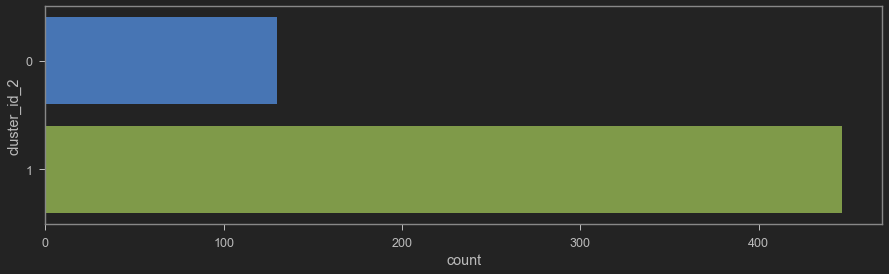

In [321]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_2', data=clusters_kproto_pca)

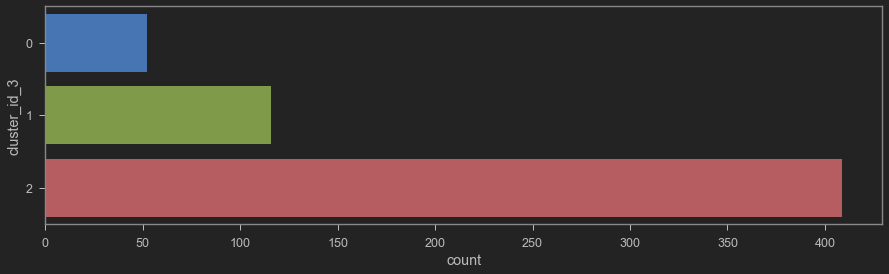

In [322]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_3', data=clusters_kproto_pca)

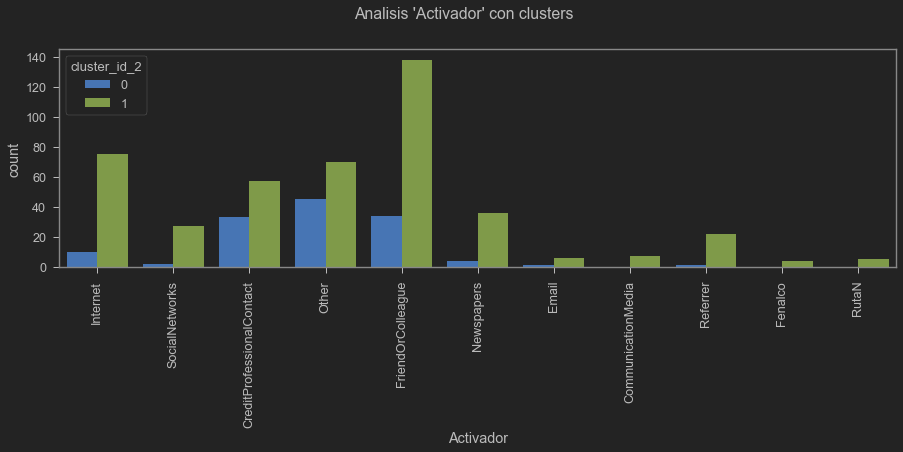

In [323]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', x='Activador', data=clusters_kproto_pca)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

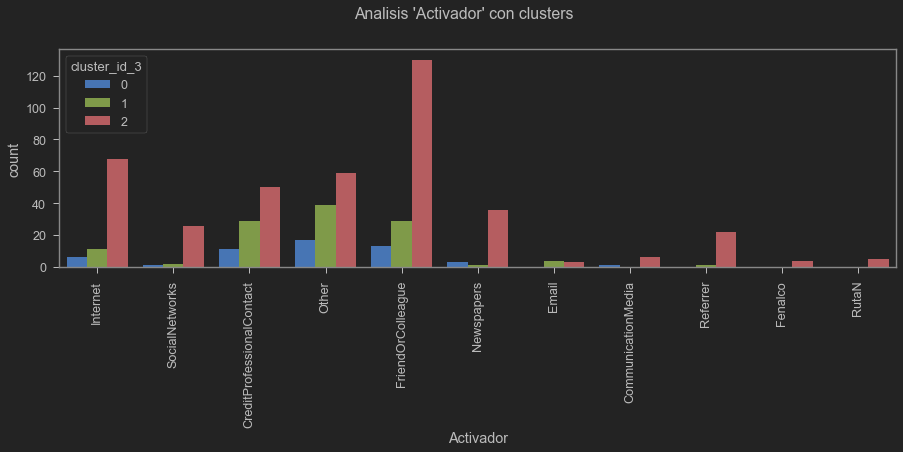

In [324]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', x='Activador', data=clusters_kproto_pca)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

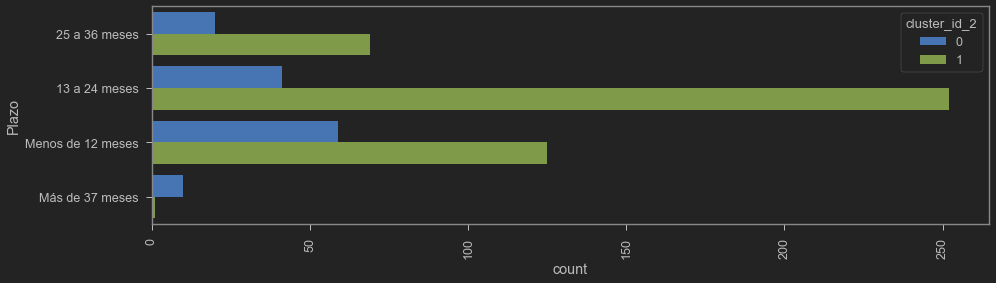

In [325]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', y='Plazo', data=clusters_kproto_pca)
plt.xticks(rotation=90)
plt.show()

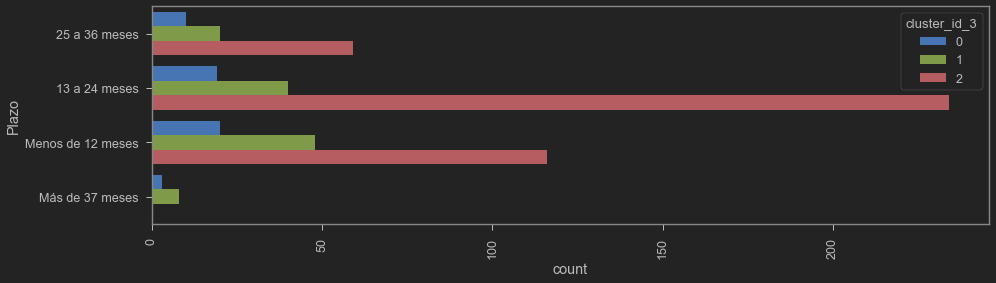

In [326]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', y='Plazo', data=clusters_kproto_pca)
plt.xticks(rotation=90)
plt.show()

<Figure size 1080x288 with 0 Axes>

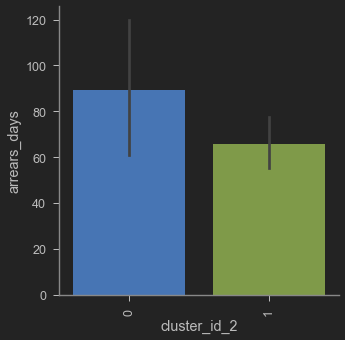

In [327]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='arrears_days', data=clusters_kproto_pca, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [328]:
clusters_kproto.groupby('cluster_id_2')['arrears_days'].mean()

cluster_id_2
0    89.392308
1    65.604027
Name: arrears_days, dtype: float64

<Figure size 1080x288 with 0 Axes>

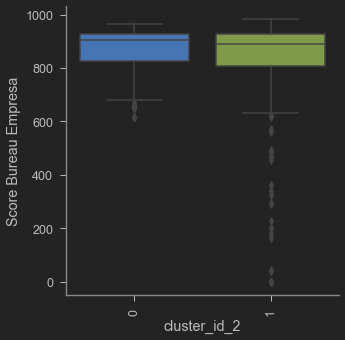

In [329]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Score Bureau Empresa', data=clusters_kproto_pca, kind='box')
plt.xticks(rotation=90)
plt.show()

<Figure size 1080x288 with 0 Axes>

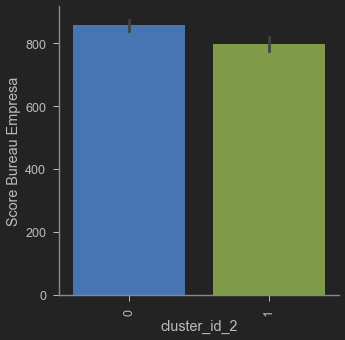

In [330]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Score Bureau Empresa', data=clusters_kproto_pca, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [331]:
clusters_kproto_pca.groupby('cluster_id_2')['Score Bureau Empresa'].mean()

cluster_id_2
0    857.330769
1    798.805369
Name: Score Bureau Empresa, dtype: float64

<Figure size 1080x288 with 0 Axes>

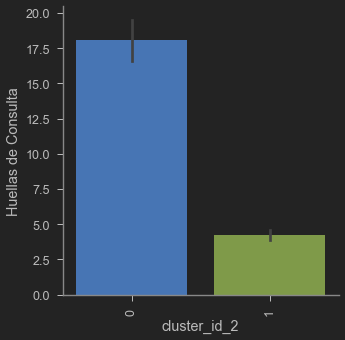

In [332]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Huellas de Consulta', data=clusters_kproto_pca, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [333]:
clusters_kproto_pca.groupby('cluster_id_2')['Huellas de Consulta'].mean()

cluster_id_2
0    18.084615
1     4.232662
Name: Huellas de Consulta, dtype: float64

### K-prototypes con FAMD Score Bureau

In [278]:
Z_fmd

array([[0.3301938488710758, -1.150895155918663, 0.9419551934826883],
       [0.10980076873660319, -0.8552279534924426, 0.9419551934826883],
       [-1.1583173247407488, -0.10024542523753205, 0.9409368635437881],
       ...,
       [-0.589978165211882, 0.4349938234768194, 0.9276985743380854],
       [0.5389114691266985, -1.413043137994458, 0.9368635437881873],
       [-0.8473478777267304, 1.1502348626583898, 0.23014256619144602]],
      dtype=object)

In [279]:
kproto_3_famd = KPrototypes(n_clusters= 3, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_3_famd = kproto_3_famd.fit_predict(Z, categorical=[2])

Best run was number 5


In [280]:
kproto_2_famd = KPrototypes(n_clusters= 2, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_2_famd = kproto_2_famd.fit_predict(Z, categorical=[2])

Best run was number 1


In [281]:
clusters_2_famd.shape

(577,)

In [282]:
clusters_kproto_fmd=pd.DataFrame(data_transform_2)
clusters_kproto_fmd
clusters_kproto_fmd['cluster_id_2'] = clusters_2
clusters_kproto_fmd['cluster_id_3'] = clusters_3_famd
clusters_kproto_fmd.reset_index(inplace=True)
#clusters_kproto.drop(['index', 'level_0'],axis=1, inplace=True)

In [283]:
clusters_kproto_fmd.head()

,index,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos,cluster_id_2,cluster_id_3
0,0,PAID,17,147915805,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2,1,0
1,1,PAID,23,91852726,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2,1,1
2,2,PAID,14,15211138,50000000,KT - EX,13 a 24 meses,Servicios,Seed,Medellín,3,No,No,924,2,Si,No,Si,No,32,SocialNetworks,3,No,Si,3,No,0,1,1
3,3,PAID,64,8713879,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0,1,1
4,4,PAID,64,8102608,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0,1,1


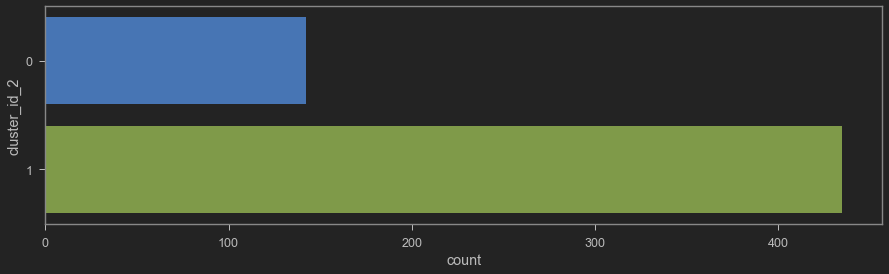

In [284]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_2', data=clusters_kproto_fmd)

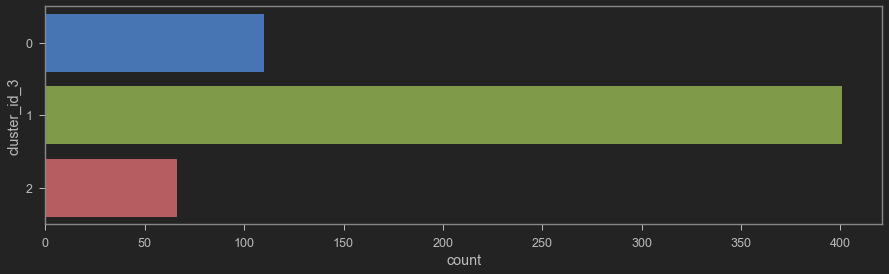

In [285]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_3', data=clusters_kproto_fmd)

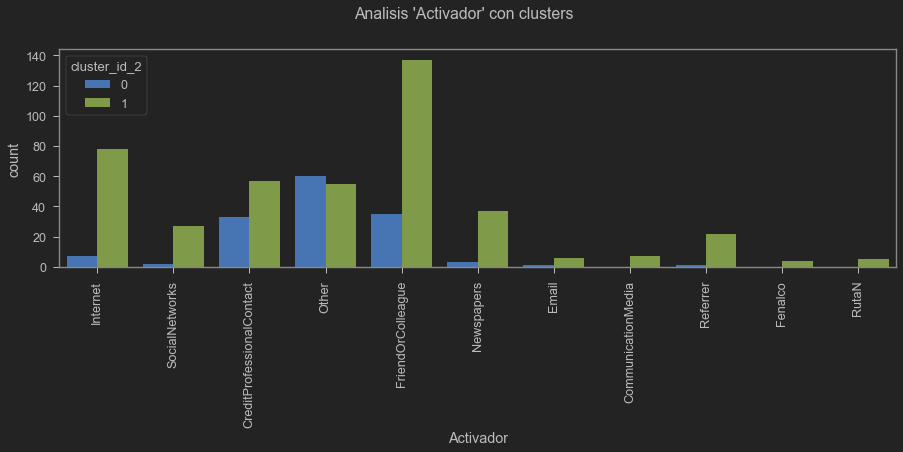

In [286]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', x='Activador', data=clusters_kproto_fmd)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

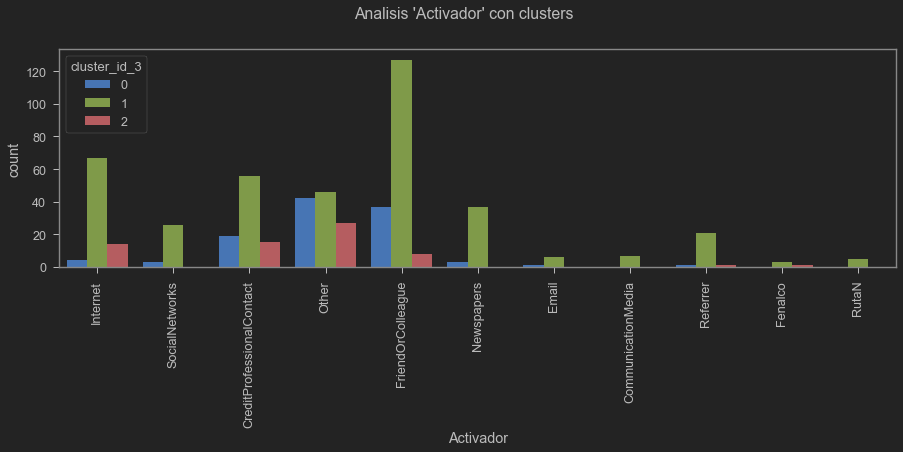

In [287]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', x='Activador', data=clusters_kproto_fmd)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

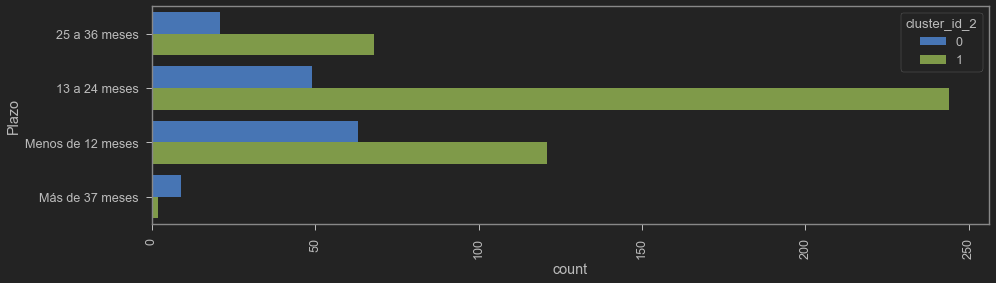

In [288]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', y='Plazo', data=clusters_kproto_fmd)
plt.xticks(rotation=90)
plt.show()

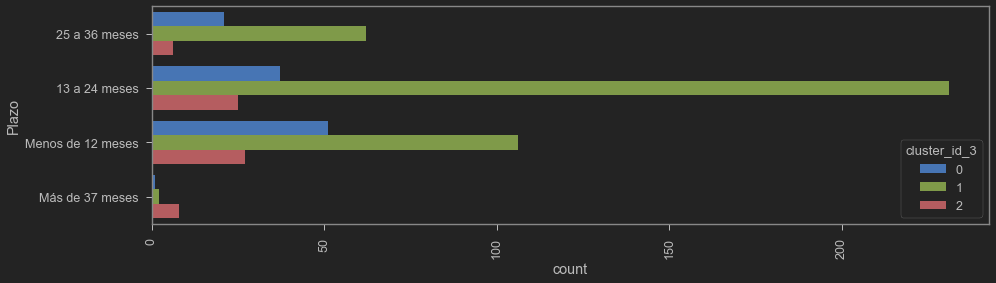

In [289]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', y='Plazo', data=clusters_kproto_fmd)
plt.xticks(rotation=90)
plt.show()

<Figure size 1080x288 with 0 Axes>

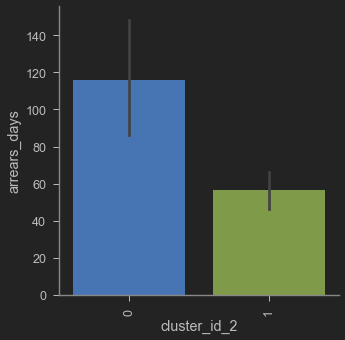

In [290]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='arrears_days', data=clusters_kproto_fmd, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [291]:
clusters_kproto_fmd.groupby('cluster_id_2')['arrears_days'].mean()

cluster_id_2
0    115.809859
1     56.324138
Name: arrears_days, dtype: float64

<Figure size 1080x288 with 0 Axes>

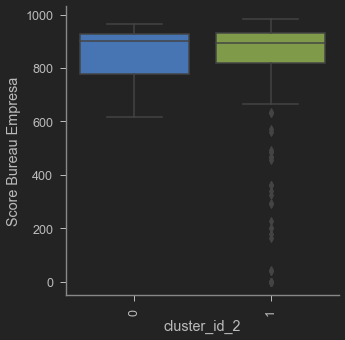

In [292]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Score Bureau Empresa', data=clusters_kproto_fmd, kind='box')
plt.xticks(rotation=90)
plt.show()

<Figure size 1080x288 with 0 Axes>

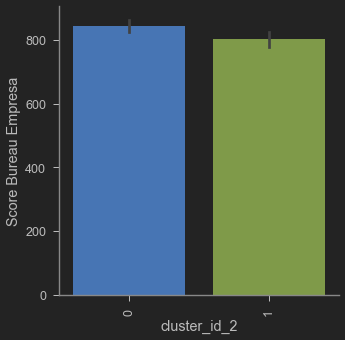

In [293]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Score Bureau Empresa', data=clusters_kproto_fmd, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [294]:
clusters_kproto_fmd.groupby('cluster_id_2')['Score Bureau Empresa'].mean()

cluster_id_2
0    842.915493
1    801.896552
Name: Score Bureau Empresa, dtype: float64

<Figure size 1080x288 with 0 Axes>

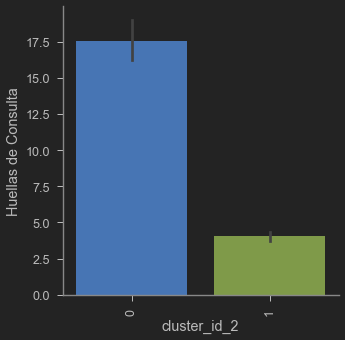

In [295]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Huellas de Consulta', data=clusters_kproto_fmd, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [296]:
clusters_kproto_fmd.groupby('cluster_id_2')['Huellas de Consulta'].mean()

cluster_id_2
0    17.549296
1     4.025287
Name: Huellas de Consulta, dtype: float64

### K-prototypes con FAMD arrears_days

In [340]:
Z_famd

array([[0.3301938488710758, -1.150895155918663, 0.01569713758079409],
       [0.10980076873660319, -0.8552279534924426, 0.02123730378578024],
       [-1.1583173247407488, -0.10024542523753205, 0.012927054478301015],
       ...,
       [-0.589978165211882, 0.4349938234768194, 0.05263157894736842],
       [0.5389114691266985, -1.413043137994458, 0.0],
       [-0.8473478777267304, 1.1502348626583898, 0.0009233610341643582]],
      dtype=object)

In [341]:
kproto_3_famd = KPrototypes(n_clusters= 3, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_3_famd = kproto_3_famd.fit_predict(Z, categorical=[2])

Best run was number 5


In [342]:
kproto_2_famd = KPrototypes(n_clusters= 2, init='Huang', n_jobs= -2, verbose=2, max_iter=20, random_state=42,gamma=0.15)
clusters_2_famd = kproto_2_famd.fit_predict(Z, categorical=[2])

Best run was number 1


In [343]:
clusters_2_famd.shape

(577,)

In [363]:
clusters_kproto_fmd=pd.DataFrame(data_transform_2)
clusters_kproto_fmd
clusters_kproto_fmd['cluster_id_2'] = clusters_2_famd
clusters_kproto_fmd['cluster_id_3'] = clusters_3_famd
#clusters_kproto_famd.reset_index(inplace=True)
#clusters_kproto_famd.drop(['index', 'level_0'],axis=1, inplace=True)

In [364]:
clusters_kproto_fmd.head()

,level_0,index,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos,cluster_id_2,cluster_id_3
0,0,0,PAID,17,147915805,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2,1,0
1,1,1,PAID,23,91852726,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2,1,1
2,2,2,PAID,14,15211138,50000000,KT - EX,13 a 24 meses,Servicios,Seed,Medellín,3,No,No,924,2,Si,No,Si,No,32,SocialNetworks,3,No,Si,3,No,0,1,1
3,3,3,PAID,64,8713879,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0,1,1
4,4,4,PAID,64,8102608,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0,1,1


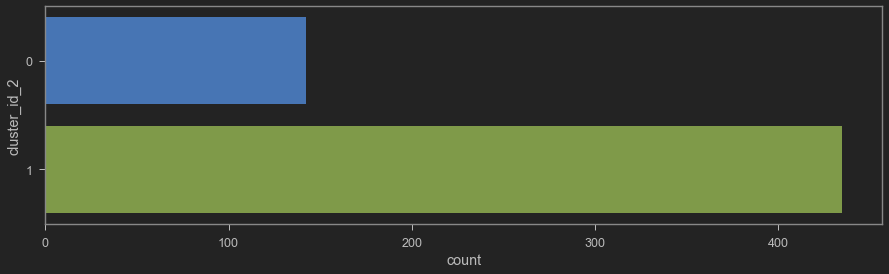

In [365]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_2', data=clusters_kproto_fmd)

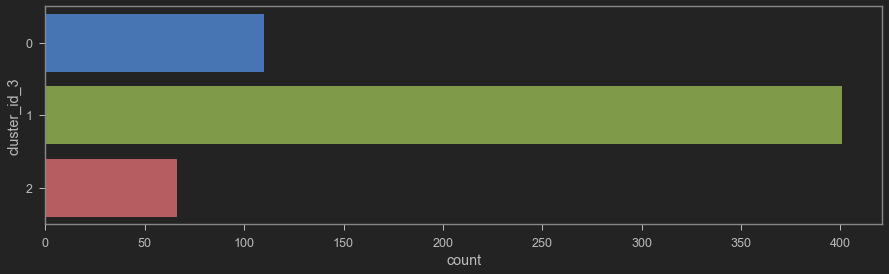

In [366]:
plt.figure(figsize=(15,4))
g = sns.countplot(y='cluster_id_3', data=clusters_kproto_fmd)

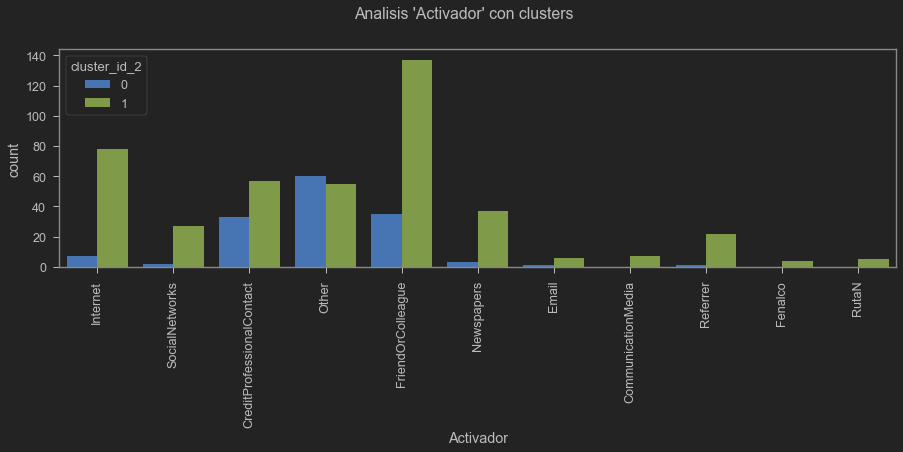

In [367]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', x='Activador', data=clusters_kproto_fmd)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

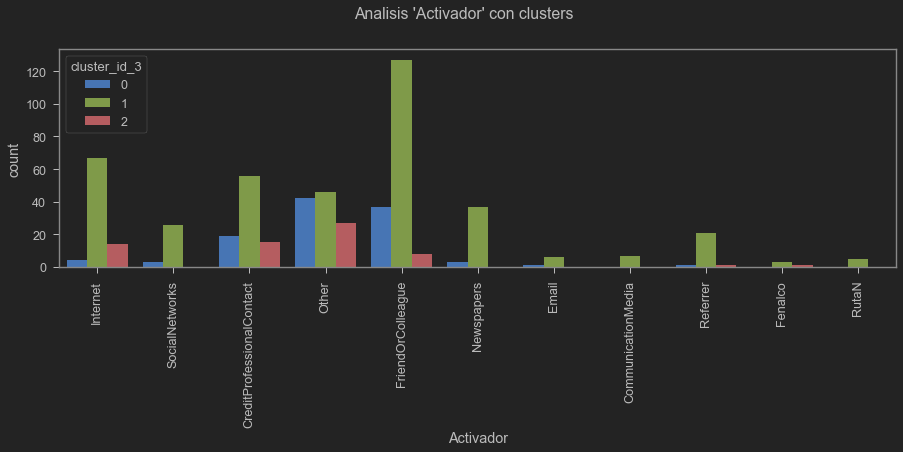

In [368]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', x='Activador', data=clusters_kproto_fmd)
plt.suptitle("Analisis 'Activador' con clusters", y=1.03)
plt.xticks(rotation=90)
plt.show()

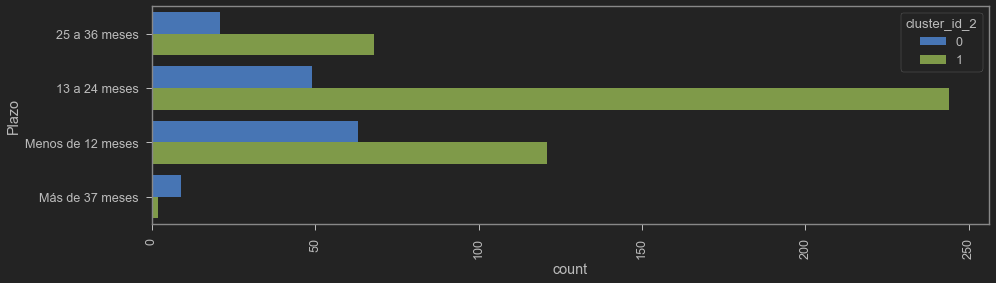

In [369]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_2', y='Plazo', data=clusters_kproto_fmd)
plt.xticks(rotation=90)
plt.show()

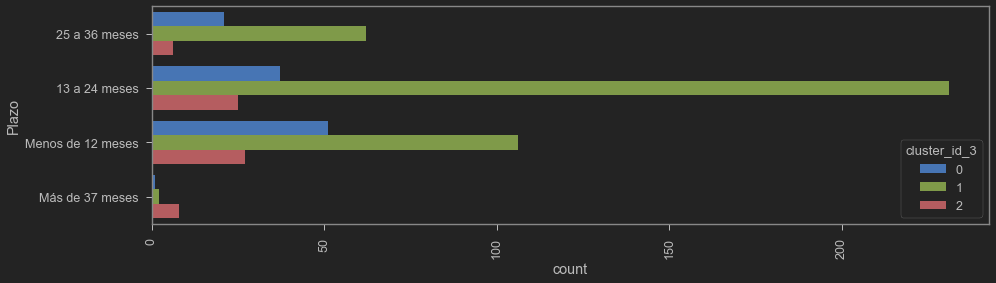

In [370]:
plt.figure(figsize=(15,4))
g = sns.countplot(hue='cluster_id_3', y='Plazo', data=clusters_kproto_fmd)
plt.xticks(rotation=90)
plt.show()

<Figure size 1080x288 with 0 Axes>

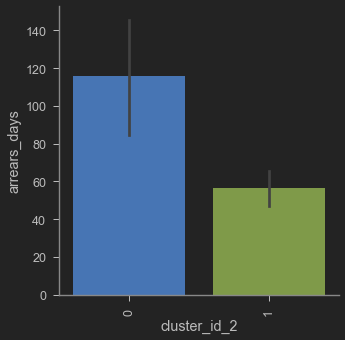

In [371]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='arrears_days', data=clusters_kproto_fmd, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [372]:
clusters_kproto_fmd.groupby('cluster_id_2')['arrears_days'].mean()

cluster_id_2
0    115.809859
1     56.324138
Name: arrears_days, dtype: float64

<Figure size 1080x288 with 0 Axes>

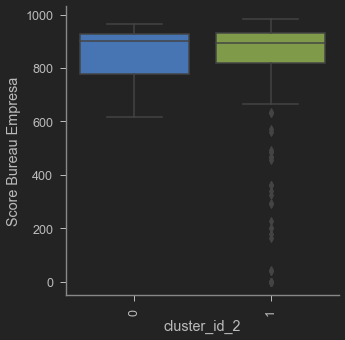

In [373]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Score Bureau Empresa', data=clusters_kproto_fmd, kind='box')
plt.xticks(rotation=90)
plt.show()

<Figure size 1080x288 with 0 Axes>

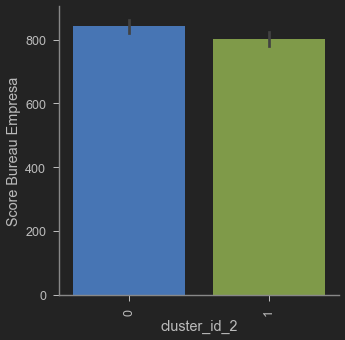

In [374]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Score Bureau Empresa', data=clusters_kproto_fmd, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [375]:
clusters_kproto_fmd.groupby('cluster_id_2')['Score Bureau Empresa'].mean()

cluster_id_2
0    842.915493
1    801.896552
Name: Score Bureau Empresa, dtype: float64

<Figure size 1080x288 with 0 Axes>

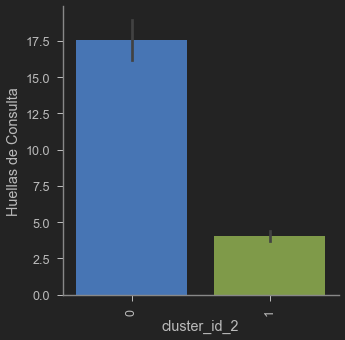

In [376]:
plt.figure(figsize=(15,4))
g = sns.catplot(x='cluster_id_2', y='Huellas de Consulta', data=clusters_kproto_fmd, kind='bar')
plt.xticks(rotation=90)
plt.show()

In [377]:
clusters_kproto_fmd.groupby('cluster_id_2')['Huellas de Consulta'].mean()

cluster_id_2
0    17.549296
1     4.025287
Name: Huellas de Consulta, dtype: float64

In [381]:
clusters_kproto_fmd

,state,arrears_days,total_paid,Monto Acumulado,Uso de los recursos,Plazo,Sector,Ingresos,Ubicación,Estrato Mínimo,Procesos judiciales,Alertas,Score Bureau Empresa,Huellas de Consulta,Website empresa,Instagram empresa,LinkedIn empresa,LinkedIn empresarios,Edad empresarios,Activador,Número de accionistas,Impacto,Acceso previso a la banca,# Empleados,Mujeres empresarias,Mujeres en cargos directivos,cluster_id_2,cluster_id_3
0,PAID,17,147915805,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2,1,0
1,PAID,23,91852726,250000000,CR,25 a 36 meses,Servicios,Seed,Medellín,5,No,No,925,8,Si,Si,Si,Si,45,Internet,2,No,Si,16,No,2,1,1
2,PAID,14,15211138,50000000,KT - EX,13 a 24 meses,Servicios,Seed,Medellín,3,No,No,924,2,Si,No,Si,No,32,SocialNetworks,3,No,Si,3,No,0,1,1
3,PAID,64,8713879,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0,1,1
4,PAID,64,8102608,40000000,SP,13 a 24 meses,Industria,Seed,Medellín,4,No,No,861,1,Si,No,Si,Si,44,CreditProfessionalContact,2,No,Si,5,No,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572,LATE,29,16038476,50000000,KT - CO,13 a 24 meses,Servicios,Seed,Bogotá D.C.,5,No,No,967,2,Si,Si,No,Si,39,SocialNetworks,2,No,Si,6,No,0,1,1
573,LATE,4,36277437,200000000,KT - EX,25 a 36 meses,Servicios,Venture,Bogotá D.C.,4,No,Si,892,5,Si,No,Si,Si,38,CommunicationMedia,1,No,Si,18,No,3,1,1
574,LATE,57,23829284,130000000,CR,25 a 36 meses,Servicios,Venture,Bogotá D.C.,4,No,No,911,2,No,No,No,No,35,Internet,3,Si,Si,14,No,5,1,1
575,PAID,0,85184813,400000000,KT - EX,25 a 36 meses,Servicios,Venture,Medellín,6,No,Si,920,2,Si,Si,No,Si,38,SocialNetworks,2,Si,Si,12,No,9,1,0


In [380]:
clusters_kproto_fmd.drop(['index', 'level_0'],axis=1, inplace=True)

In [382]:
clusters_kproto_fmd.to_csv('clusters_FAMD.csv')

In [ ]:
clusters_kproto.to_csv('clusters_PCA.csv')

### Para probar
* Ensayar con 2 componentes
* Escoger el mejor componente 

In [175]:
import pandas as pd

X = pd.DataFrame(
    data=[
         ['A', 'A', 'A', 2, 5, 7, 6, 3, 6, 7],
         ['A', 'A', 'A', 4, 4, 4, 2, 4, 4, 3],
         ['B', 'A', 'B', 5, 2, 1, 1, 7, 1, 1],
         ['B', 'A', 'B', 7, 2, 1, 2, 2, 2, 2],
         ['B', 'B', 'B', 3, 5, 6, 5, 2, 6, 6],
         ['B', 'B', 'A', 3, 5, 4, 5, 1, 7, 5]
     ],
     columns=['E1 fruity', 'E1 woody', 'E1 coffee',
              'E2 red fruit', 'E2 roasted', 'E2 vanillin', 'E2 woody',
              'E3 fruity', 'E3 butter', 'E3 woody'],
     index=['Wine {}'.format(i+1) for i in range(6)])

X['Oak type'] = [1, 2, 2, 2, 1, 1]

In [176]:
X

,E1 fruity,E1 woody,E1 coffee,E2 red fruit,E2 roasted,E2 vanillin,E2 woody,E3 fruity,E3 butter,E3 woody,Oak type
Wine 1,A,A,A,2,5,7,6,3,6,7,1
Wine 2,A,A,A,4,4,4,2,4,4,3,2
Wine 3,B,A,B,5,2,1,1,7,1,1,2
Wine 4,B,A,B,7,2,1,2,2,2,2,2
Wine 5,B,B,B,3,5,6,5,2,6,6,1
Wine 6,B,B,A,3,5,4,5,1,7,5,1


In [207]:
import prince
famd = prince.FAMD(
     n_components=2,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
)
famd = famd.fit(X.drop('Oak type', axis='columns'))

In [208]:
famd.row_coordinates(X)

,0,1
Wine 1,-1.488689,-1.002711
Wine 2,-0.449783,-1.354847
Wine 3,1.774255,-0.258528
Wine 4,1.565402,0.016484
Wine 5,-0.349655,1.516425
Wine 6,-1.051531,1.083178


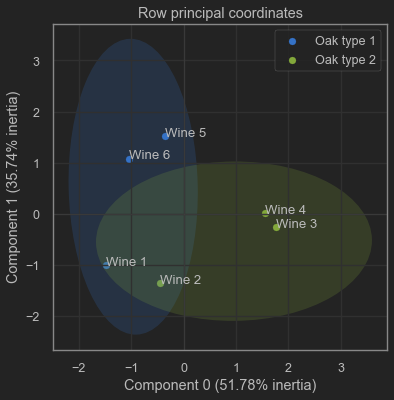

In [209]:
ax = famd.plot_row_coordinates(
     X,
     ax=None,
     figsize=(6, 6),
     x_component=0,
     y_component=1,
     labels=X.index,
     color_labels=['Oak type {}'.format(t) for t in X['Oak type']],
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True
)

In [184]:
#Using the tips dataset, change the size feature to string object
tips = sns.load_dataset('tips')
tips['size'] = tips['size'].astype('object')
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


In [203]:
from prince import FAMD
famd = FAMD(n_components =2, n_iter = 3, random_state = 101)
#I leave out tips as I want the sex feature as the label
famd.fit(tips.drop('sex', axis =1))
famd.transform(tips)

,0,1
0,-0.654532,-0.712168
1,-0.342964,-0.793477
2,0.773906,-0.314969
3,0.400268,-0.237451
4,1.199167,-0.009813
5,1.575306,0.170818
6,-0.770373,-0.713910
7,1.165193,-0.041970
8,-0.460836,-0.603596
9,-0.081408,-0.414881


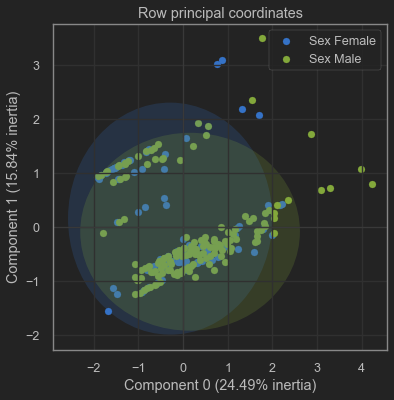

In [186]:
ax = famd.plot_row_coordinates(tips,color_labels=['Sex {}'.format(t) for t in tips['sex']] )

In [187]:
famd.partial_row_coordinates(tips)

Categorical             Numerical          
              0           1         0         1
0     42.813939 -433.075615 -1.516936 -0.709828
1    378.392882 -421.123135 -1.797714 -0.758645
2    378.392882 -421.123135  0.436027  0.198372
3     42.813939 -433.075615  0.592663  0.239605
4    454.982453 -336.123262  0.871667  0.364833
5    454.982453 -336.123262  1.623946  0.726095
6     42.813939 -433.075615 -1.748618 -0.713314
7    454.982453 -336.123262  0.803720  0.300518
8     42.813939 -433.075615 -1.129546 -0.492685
9     42.813939 -433.075615 -0.370688 -0.115256
10    42.813939 -433.075615 -1.773974 -0.746004
11   454.982453 -336.123262  2.827061  1.184694
12    42.813939 -433.075615 -1.331760 -0.597443
13   454.982453 -336.123262 -0.138166 -0.049825
14    42.813939 -433.075615 -0.495449 -0.177405
15    42.813939 -433.075615  0.754345  0.347549
16   378.392882 -421.123135 -1.792555 -0.755968
17   378.392882 -421.123135  0.081264  0.087113
18   378.392882 -421.123135  0.021193  0.048357
19   315.411211 -572.768762  0.306279  0.139286
20   -20.167732 -584.721242  0.477497  0.260411
21   -20.167732 -584.721242 -0.101815 -0.056956
22   -20.167732 -584.721242 -0.887580 -0.383285
23   392.000782 -487.768889  4.850069  2.125523
24   -20.167732 -584.721242  0.115900  0.056652
25   392.000782 -487.768889 -0.610070 -0.274008
26   -20.167732 -584.721242 -1.276282 -0.542505
27   -20.167732 -584.721242 -1.346106 -0.567755
28   -20.167732 -584.721242  1.001715  0.467826
29   -20.167732 -584.721242 -0.012894 -0.004523
30   -20.167732 -584.721242 -2.008727 -0.851985
31   392.000782 -487.768889 -0.455654 -0.205190
32   -20.167732 -584.721242 -0.484203 -0.174961
33   392.000782 -487.768889 -0.246306 -0.133540
34   -20.167732 -584.721242 -0.037901  0.008333
35   315.411211 -572.768762  0.811060  0.342105
36   315.411211 -572.768762 -0.974398 -0.433336
37   315.411211 -572.768762 -0.248890 -0.084188
38   315.411211 -572.768762 -0.538266 -0.250476
39   315.411211 -572.768762  2.417361  1.036535
40   315.411211 -572.768762 -0.853671 -0.370212
41    42.813939 -433.075615 -0.522299 -0.226047
42    42.813939 -433.075615 -0.562094 -0.198261
43    42.813939 -433.075615 -2.075790 -0.886781
44   454.982453 -336.123262  2.699157  1.187105
45    42.813939 -433.075615 -0.152541 -0.055023
46    42.813939 -433.075615  1.489119  0.700859
47   454.982453 -336.123262  3.151939  1.383285
48   378.392882 -421.123135  0.313353  0.036404
49    42.813939 -433.075615 -0.178212 -0.064306
50    42.813939 -433.075615 -1.052234 -0.420929
51    42.813939 -433.075615 -1.221414 -0.473998
52   454.982453 -336.123262  2.904564  1.228942
53    42.813939 -433.075615 -1.900641 -0.803976
54   454.982453 -336.123262  1.422808  0.623348
55    42.813939 -433.075615  0.286136  0.144979
56   406.267862 -709.233689  1.872342  0.677227
57   -20.167732 -584.721242 -0.246587 -0.210694
58    -5.900652 -806.186042 -1.643446 -0.694746
59   392.000782 -487.768889  5.233037  2.195073
60    -5.900652 -806.186042  0.182717  0.083247
61    -5.900652 -806.186042 -1.231102 -0.526167
62    -5.900652 -806.186042 -1.529955 -0.635862
63   406.267862 -709.233689  0.317555  0.176617
64   315.411211 -572.768762 -0.447095 -0.190740
65   315.411211 -572.768762  0.124041  0.057162
66   -20.167732 -584.721242 -0.669306 -0.284886
67   229.183669 -761.358549 -2.952451 -1.229758
68   -20.167732 -584.721242 -0.565700 -0.284729
69    -5.900652 -806.186042 -1.052215 -0.454177
70   -20.167732 -584.721242 -1.433459 -0.601777
71   315.411211 -572.768762 -0.277813 -0.100325
72    -5.900652 -806.186042  0.814037  0.305872
73    -5.900652 -806.186042  1.802298  0.814113
74   -20.167732 -584.721242 -1.012926 -0.431047
75   -20.167732 -584.721242 -2.033862 -0.877296
76    -5.900652 -806.186042 -0.141050 -0.044379
77  -186.801008  919.719106  1.380900  0.580616
78  -598.969522  822.766753  0.306446  0.110958
79  -598.969522  822.766753 -0.434602 -0.180545
80  -584.702443  601.301954 -0.034457 -0.012321
81  -598.969522  822

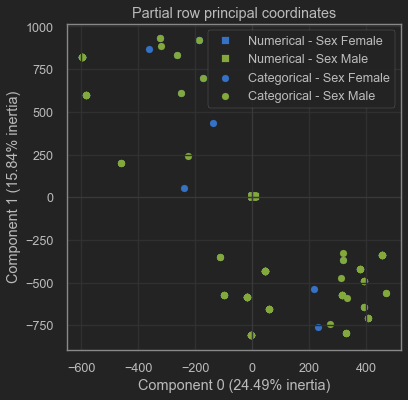

In [188]:
ax = famd.plot_partial_row_coordinates(tips, color_labels=['Sex {}'.format(t) for t in tips['sex']])

In [189]:
famd.explained_inertia_

array([0.24485193, 0.15835335])

In [201]:
famd.eigenvalues_

array([0.00525495, 0.00339854])